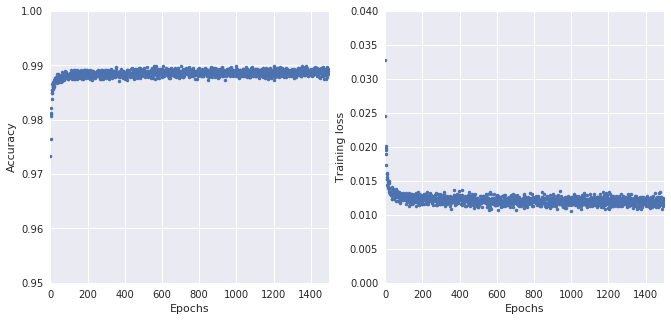

In [1]:
#Changes were made to filepaths in fileIO.py ...
import _pickle as cPickle
import pickle as Pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
with open('/home/shenqin/Local/CellCount/dat/results/' + 'Data_v2_Run_v3epochs_1500-summary.pkl', 'rb') as file_pi:
        summary = Pickle.load(file_pi)
plt.figure(figsize=(11,5))
plt.subplot(1,2,1,ylabel='Accuracy',xlabel='Epochs',xlim=(0,1500),ylim=(0.95,1))
plt.plot(summary['acc'],'.')
plt.subplot(1,2,2,ylabel='Training loss',xlabel='Epochs',xlim=(0,1500),ylim=(0,0.04))
plt.plot(summary['loss'],'.')

In [1]:
import os
import pdb
import pickle as Pickle
import sys
import time
import timeit
from random import shuffle


#import keras.activations.softmax as Softmax
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import (Concatenate, Conv2D, Cropping2D, Dropout, Input,
                          MaxPooling2D, UpSampling2D, Dense, Activation)
from keras.losses import binary_crossentropy, mean_squared_error
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

import _pickle as cPickle
import fileIO
import im3dscroll as I
from custom_dataloader import DataGenerator
from dataclass import dataset, combine_patches
import pdb

base_path, rel_im_path, rel_lbl_path, rel_result_path = fileIO.set_paths()[0:4]

#Define model
conv_properties = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
input_im = Input(shape=(128, 128, 1), name='input_im')

conv1 = Conv2D(8, 3, **conv_properties)(input_im)   # (batch, 128,128,8)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)	    # (batch, 64, 64, 8)

conv2 = Conv2D(8, 3, **conv_properties)(pool1)      # (batch, 64, 64, 8)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)	    # (batch, 32, 32, 8)

conv3 = Conv2D(4, 3, **conv_properties)(pool2)		# (batch, 32, 32, 4)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)	    # (batch, 16, 16, 4)

conv4 = Conv2D(4, 3, **conv_properties)(pool3)		# (batch, 16, 16, 4)
drop4 = Dropout(0.2)(conv4)						    # (batch, 16, 16, 4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)	    # (batch, 8, 8, 4)

conv5 = Conv2D(4, 3, **conv_properties)(pool4)		# (batch, 8, 8, 4)
drop5 = Dropout(0.2)(conv5)						    # (batch, 8, 8, 4)

up6 = UpSampling2D(size=(2, 2))(drop5)			    # (batch, 16, 16, 4)
up6 = Conv2D(4, 2, **conv_properties)(up6)		    # (batch, 16, 16, 4)
cat6 = Concatenate(axis=3)([drop4, up6])  		    # (batch, 16, 16, 4)
conv6 = Conv2D(4, 3, **conv_properties)(cat6)		# (batch, 16, 16, 4)

up7 = UpSampling2D(size=(2, 2))(conv6)			    # (batch, 32, 32, 4)
up7 = Conv2D(4, 2, **conv_properties)(up7)		    # (batch, 32, 32, 4)
cat7 = Concatenate(axis=3)([conv3, up7])		    # (batch, 32, 32, 8)
conv7 = Conv2D(4, 3, **conv_properties)(cat7)		# (batch, 32, 32, 4)

up8 = UpSampling2D(size=(2, 2))(conv7)			    # (batch, 64, 64, 4)
up8 = Conv2D(8, 2, **conv_properties)(up8)		    # (batch, 64, 64, 8)
cat8 = Concatenate(axis=3)([conv2, up8])  		    # (batch, 64, 64, 16)
conv8 = Conv2D(8, 3, **conv_properties)(cat8)		# (batch, 64, 64, 8)

up9 = UpSampling2D(size=(2, 2))(conv8)			    # (batch, 128,128, 8)
up9 = Conv2D(8, 2, **conv_properties)(up9)		    # (batch, 128,128, 8)
cat9 = Concatenate(axis=3)([conv1, up9])  		    # (batch, 128,128, 16)
conv9 = Conv2D(8, 3, **conv_properties)(cat9)		# (batch, 128,128, 8) 


output_im = Conv2D(3,1, activation='softmax', name='output_im')(conv9)
Unet = Model(inputs=[input_im], outputs=[output_im])

#Load weights
Unet.load_weights('/home/shenqin/Local/CellCount/dat/results/Data_v2_Run_v3epochs_1500/1500.h5')

/home/shenqin/Envs/Py3ML/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imlist = os.listdir(base_path+rel_im_path)
imlist = [item.split('.tif')[0] for item in imlist if '.tif' in item]
imlist.sort()

In [5]:
#New prediction method. Inner pad is hard coded to be ~cell size.
from dataclass import combine_inpadded_patches
from scipy import ndimage
from tqdm import tqdm 

patchsize = 128
strel = [[1,1,1],
         [1,1,1],
         [1,1,1]]

for imid in tqdm(imlist):
    start = time.time()
    D = dataset([imid], batch_size=1, patchsize=patchsize, getpatch_algo='inpadded', \
        shuffle=False, rotate=False, flip=False, stride=(patchsize,patchsize), padding=True)
    D.load_im_lbl()
    val_im,val_lbl = D.get_patches()

    val_im_90  = np.rot90(val_im, k=1, axes=(1,2))
    val_im_180 = np.rot90(val_im, k=2, axes=(1,2))
    val_im_270 = np.rot90(val_im, k=3, axes=(1,2))

    val_lbl_pred     = Unet.predict(val_im,     batch_size=100, verbose=1)
    val_lbl_pred_90  = Unet.predict(val_im_90,  batch_size=100, verbose=1)
    val_lbl_pred_180 = Unet.predict(val_im_180, batch_size=100, verbose=1)
    val_lbl_pred_270 = Unet.predict(val_im_270, batch_size=100, verbose=1)

    val_lbl_pred_90  = np.rot90(val_lbl_pred_90,  k=3, axes=(1,2))
    val_lbl_pred_180 = np.rot90(val_lbl_pred_180, k=2, axes=(1,2))
    val_lbl_pred_270 = np.rot90(val_lbl_pred_270, k=1, axes=(1,2))

    val_lbl_pred = (val_lbl_pred+val_lbl_pred_90+val_lbl_pred_180+val_lbl_pred_270)/4

    val_lbl_bo = np.expand_dims(val_lbl_pred[:,:,:,1],axis=3)
    val_lbl_fg = np.expand_dims(val_lbl_pred[:,:,:,2],axis=3)
    val_lbl_predicted = np.expand_dims(np.argmax(val_lbl_pred, axis=3),axis=3)

    #val_lbl_full = combine_inpadded_patches(val_lbl,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_im_full =  combine_inpadded_patches(val_im,patchsize=D.patchsize, imsize=D.im_buffer[0].shape,padding=True)

    #lbl_pred_full = combine_patches(val_lbl_pred,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_fg =        combine_inpadded_patches(val_lbl_fg,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_bo =        combine_inpadded_patches(val_lbl_bo,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_predicted = combine_inpadded_patches(val_lbl_predicted,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    
    endinf = time.time()
    print('Inference took ',str(endinf - start) + ' seconds')
    
    #sio.savemat('/home/shenqin/Desktop/' +'seg'+imid+'.mat',
    #            {'bo':val_lbl_bo[0:D.im_buffer[0].shape[0],0:D.im_buffer[0].shape[1]],
    #             'fg':val_lbl_fg[0:D.im_buffer[0].shape[0],0:D.im_buffer[0].shape[1]]})
    #endsave = time.time()
    #print('Saving took ',str(endsave - endinf) + ' seconds')
    
    #Inferred cell centers to csv: 
    fg = val_lbl_fg[0:D.im_buffer[0].shape[0],0:D.im_buffer[0].shape[1]]
    bo = val_lbl_bo[0:D.im_buffer[0].shape[0],0:D.im_buffer[0].shape[1]]
    im = val_im_full[0:D.im_buffer[0].shape[0],0:D.im_buffer[0].shape[1]]
    thr_im = fg-bo>0.5

    #Matlab equivalent connected component labeling:
    lbl,num_features = ndimage.label(thr_im,structure=strel)

    #Find center of mass for the labeled objects
    com = ndimage.measurements.center_of_mass(thr_im, labels=lbl,index=range(1,num_features+1))
    com = np.array(com)

    #Save data
    np.savetxt('/home/shenqin/Local/5Brains/577771849_299769_0500350626-Results/'+ imid + '.csv', com,fmt='%.1f', delimiter=",")
    end = time.time()
    print('Morphological ops took ',str(end - endinf) + ' seconds')
    

  0%|          | 0/701 [00:00<?, ?it/s]

17980/17980 [==============================] - 6s 358us/step
Inference took  54.18589520454407 seconds


  0%|          | 1/701 [01:06<12:52:34, 66.22s/it]

Morphological ops took  12.034276008605957 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.15456509590149 seconds


  0%|          | 2/701 [02:13<12:56:53, 66.69s/it]

Morphological ops took  12.618870735168457 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  55.27308917045593 seconds


  0%|          | 3/701 [03:21<12:59:05, 66.97s/it]

Morphological ops took  12.360241889953613 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.83932590484619 seconds


  1%|          | 4/701 [04:28<12:58:31, 67.02s/it]

Morphological ops took  12.285857439041138 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.37861132621765 seconds


  1%|          | 5/701 [05:36<12:59:45, 67.22s/it]

Morphological ops took  12.315860748291016 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.11136531829834 seconds


  1%|          | 6/701 [06:43<12:59:13, 67.27s/it]

Morphological ops took  12.27567195892334 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.98734498023987 seconds


  1%|          | 7/701 [07:51<12:58:00, 67.26s/it]

Morphological ops took  12.256981372833252 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.948548793792725 seconds


  1%|          | 8/701 [08:58<12:56:44, 67.25s/it]

Morphological ops took  12.268701553344727 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.837937355041504 seconds


  1%|▏         | 9/701 [10:05<12:55:03, 67.20s/it]

Morphological ops took  12.248695135116577 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.18339490890503 seconds


  1%|▏         | 10/701 [11:12<12:54:44, 67.27s/it]

Morphological ops took  12.249399662017822 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.07306146621704 seconds


  2%|▏         | 11/701 [12:20<12:54:14, 67.33s/it]

Morphological ops took  12.378078937530518 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.11402726173401 seconds


  2%|▏         | 12/701 [13:27<12:53:14, 67.34s/it]

Morphological ops took  12.24614143371582 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.07646298408508 seconds


  2%|▏         | 13/701 [14:34<12:52:05, 67.33s/it]

Morphological ops took  12.247953176498413 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.90214490890503 seconds


  2%|▏         | 14/701 [15:42<12:50:45, 67.32s/it]

Morphological ops took  12.372543811798096 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.49185752868652 seconds


  2%|▏         | 15/701 [16:48<12:47:34, 67.13s/it]

Morphological ops took  12.217817068099976 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.15202808380127 seconds


  2%|▏         | 16/701 [17:56<12:47:34, 67.23s/it]

Morphological ops took  12.310070276260376 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.817758083343506 seconds


  2%|▏         | 17/701 [19:03<12:46:15, 67.22s/it]

Morphological ops took  12.357988357543945 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.988266944885254 seconds


  3%|▎         | 18/701 [20:10<12:45:12, 67.22s/it]

Morphological ops took  12.245837211608887 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  56.15424656867981 seconds


  3%|▎         | 19/701 [21:19<12:49:47, 67.72s/it]

Morphological ops took  12.739475965499878 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.005966901779175 seconds


  3%|▎         | 20/701 [22:26<12:46:59, 67.58s/it]

Morphological ops took  12.223868370056152 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.63017416000366 seconds


  3%|▎         | 21/701 [23:33<12:43:16, 67.35s/it]

Morphological ops took  12.182841062545776 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.74393606185913 seconds


  3%|▎         | 22/701 [24:40<12:40:46, 67.23s/it]

Morphological ops took  12.196788311004639 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.30576038360596 seconds


  3%|▎         | 23/701 [25:47<12:37:08, 67.00s/it]

Morphological ops took  12.179953575134277 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.88715648651123 seconds


  3%|▎         | 24/701 [26:54<12:36:19, 67.03s/it]

Morphological ops took  12.201685190200806 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.62777233123779 seconds


  4%|▎         | 25/701 [28:01<12:34:35, 66.98s/it]

Morphological ops took  12.219440698623657 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.707547187805176 seconds


  4%|▎         | 26/701 [29:08<12:33:15, 66.96s/it]

Morphological ops took  12.201671838760376 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.54005813598633 seconds


  4%|▍         | 27/701 [30:14<12:31:37, 66.91s/it]

Morphological ops took  12.261234283447266 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.67434358596802 seconds


  4%|▍         | 28/701 [31:21<12:30:29, 66.91s/it]

Morphological ops took  12.228811502456665 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.77002143859863 seconds


  4%|▍         | 29/701 [32:28<12:29:33, 66.93s/it]

Morphological ops took  12.19463062286377 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.689270973205566 seconds


  4%|▍         | 30/701 [33:35<12:28:22, 66.92s/it]

Morphological ops took  12.214811086654663 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.45562815666199 seconds


  4%|▍         | 31/701 [34:42<12:26:16, 66.83s/it]

Morphological ops took  12.167775869369507 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.30307054519653 seconds


  5%|▍         | 32/701 [35:48<12:24:01, 66.73s/it]

Morphological ops took  12.187000751495361 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.38211727142334 seconds


  5%|▍         | 33/701 [36:55<12:22:22, 66.68s/it]

Morphological ops took  12.186009645462036 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.31856727600098 seconds


  5%|▍         | 34/701 [38:01<12:20:43, 66.63s/it]

Morphological ops took  12.197506427764893 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.408803939819336 seconds


  5%|▍         | 35/701 [39:08<12:19:44, 66.64s/it]

Morphological ops took  12.258107900619507 seconds
17980/17980 [==============================] - 6s 361us/step
Inference took  54.46812105178833 seconds


  5%|▌         | 36/701 [40:15<12:18:45, 66.65s/it]

Morphological ops took  12.21411657333374 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.8251006603241 seconds


  5%|▌         | 37/701 [41:22<12:18:51, 66.76s/it]

Morphological ops took  12.195413589477539 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.685662031173706 seconds


  5%|▌         | 38/701 [42:29<12:18:09, 66.80s/it]

Morphological ops took  12.19905161857605 seconds
17980/17980 [==============================] - 7s 362us/step
Inference took  54.38251066207886 seconds


  6%|▌         | 39/701 [43:35<12:16:18, 66.73s/it]

Morphological ops took  12.19673228263855 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.6690878868103 seconds


  6%|▌         | 40/701 [44:42<12:15:36, 66.77s/it]

Morphological ops took  12.189308166503906 seconds
17980/17980 [==============================] - 6s 361us/step
Inference took  54.61442041397095 seconds


  6%|▌         | 41/701 [45:49<12:14:30, 66.77s/it]

Morphological ops took  12.160545349121094 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.513901233673096 seconds


  6%|▌         | 42/701 [46:56<12:13:13, 66.76s/it]

Morphological ops took  12.20688772201538 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.664087533950806 seconds


  6%|▌         | 43/701 [48:02<12:12:42, 66.81s/it]

Morphological ops took  12.271620750427246 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.919559717178345 seconds


  6%|▋         | 44/701 [49:10<12:13:09, 66.96s/it]

Morphological ops took  12.371335744857788 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.488014459609985 seconds


  6%|▋         | 45/701 [50:17<12:11:44, 66.93s/it]

Morphological ops took  12.372672319412231 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.57652735710144 seconds


  7%|▋         | 46/701 [51:23<12:10:08, 66.88s/it]

Morphological ops took  12.204109907150269 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.763854026794434 seconds


  7%|▋         | 47/701 [52:30<12:09:18, 66.91s/it]

Morphological ops took  12.200883150100708 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.234604597091675 seconds


  7%|▋         | 48/701 [53:37<12:06:40, 66.77s/it]

Morphological ops took  12.210118055343628 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.7217800617218 seconds


  7%|▋         | 49/701 [54:44<12:06:03, 66.82s/it]

Morphological ops took  12.19887113571167 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.58653974533081 seconds


  7%|▋         | 50/701 [55:51<12:04:52, 66.81s/it]

Morphological ops took  12.204884052276611 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.68564224243164 seconds


  7%|▋         | 51/701 [56:57<12:03:59, 66.83s/it]

Morphological ops took  12.194866418838501 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.70422887802124 seconds


  7%|▋         | 52/701 [58:04<12:03:07, 66.85s/it]

Morphological ops took  12.198086261749268 seconds
17980/17980 [==============================] - 6s 361us/step
Inference took  54.35876989364624 seconds


  8%|▊         | 53/701 [59:11<12:01:01, 66.76s/it]

Morphological ops took  12.189899206161499 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.53937578201294 seconds


  8%|▊         | 54/701 [1:00:18<12:00:16, 66.80s/it]

Morphological ops took  12.334630966186523 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.74468469619751 seconds


  8%|▊         | 55/701 [1:01:25<11:59:44, 66.85s/it]

Morphological ops took  12.22870397567749 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.773942947387695 seconds


  8%|▊         | 56/701 [1:02:32<11:59:04, 66.89s/it]

Morphological ops took  12.212554216384888 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.748475074768066 seconds


  8%|▊         | 57/701 [1:03:39<11:58:28, 66.94s/it]

Morphological ops took  12.302704811096191 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.61602830886841 seconds


  8%|▊         | 58/701 [1:04:46<11:56:57, 66.90s/it]

Morphological ops took  12.196830034255981 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.701077461242676 seconds


  8%|▊         | 59/701 [1:05:52<11:55:52, 66.90s/it]

Morphological ops took  12.206672430038452 seconds
17980/17980 [==============================] - 7s 362us/step
Inference took  54.69587230682373 seconds


  9%|▊         | 60/701 [1:06:59<11:54:46, 66.91s/it]

Morphological ops took  12.214032649993896 seconds
17980/17980 [==============================] - 6s 359us/step
Inference took  54.38074016571045 seconds


  9%|▊         | 61/701 [1:08:06<11:52:40, 66.81s/it]

Morphological ops took  12.21482229232788 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.707762002944946 seconds


  9%|▉         | 62/701 [1:09:13<11:51:54, 66.85s/it]

Morphological ops took  12.215898036956787 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.57847762107849 seconds


  9%|▉         | 63/701 [1:10:20<11:50:43, 66.84s/it]

Morphological ops took  12.242711544036865 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.48666214942932 seconds


  9%|▉         | 64/701 [1:11:26<11:49:07, 66.79s/it]

Morphological ops took  12.197606801986694 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.771848917007446 seconds


  9%|▉         | 65/701 [1:12:33<11:48:32, 66.84s/it]

Morphological ops took  12.18989372253418 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.32275605201721 seconds


  9%|▉         | 66/701 [1:13:40<11:46:28, 66.75s/it]

Morphological ops took  12.220520257949829 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.592679500579834 seconds


 10%|▉         | 67/701 [1:14:47<11:45:36, 66.78s/it]

Morphological ops took  12.234748363494873 seconds
17980/17980 [==============================] - 7s 384us/step
Inference took  55.25497317314148 seconds


 10%|▉         | 68/701 [1:15:54<11:47:22, 67.05s/it]

Morphological ops took  12.433782815933228 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.01125741004944 seconds


 10%|▉         | 69/701 [1:17:02<11:46:51, 67.11s/it]

Morphological ops took  12.227740287780762 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.37026786804199 seconds


 10%|▉         | 70/701 [1:18:08<11:44:04, 66.95s/it]

Morphological ops took  12.208976030349731 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.645500898361206 seconds


 10%|█         | 71/701 [1:19:15<11:42:33, 66.91s/it]

Morphological ops took  12.174201011657715 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.68072319030762 seconds


 10%|█         | 72/701 [1:20:22<11:41:27, 66.91s/it]

Morphological ops took  12.23425817489624 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.81498956680298 seconds


 10%|█         | 73/701 [1:21:29<11:40:42, 66.95s/it]

Morphological ops took  12.212666511535645 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.620503425598145 seconds


 11%|█         | 74/701 [1:22:36<11:39:30, 66.94s/it]

Morphological ops took  12.296371221542358 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.76625108718872 seconds


 11%|█         | 75/701 [1:23:43<11:38:28, 66.95s/it]

Morphological ops took  12.19711709022522 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.791407108306885 seconds


 11%|█         | 76/701 [1:24:50<11:37:48, 66.99s/it]

Morphological ops took  12.29617428779602 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.077417612075806 seconds


 11%|█         | 77/701 [1:25:57<11:37:44, 67.09s/it]

Morphological ops took  12.250189781188965 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.08727049827576 seconds


 11%|█         | 78/701 [1:27:05<11:37:19, 67.16s/it]

Morphological ops took  12.22371768951416 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.93760275840759 seconds


 11%|█▏        | 79/701 [1:28:12<11:36:12, 67.16s/it]

Morphological ops took  12.22452163696289 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.88974738121033 seconds


 11%|█▏        | 80/701 [1:29:19<11:34:56, 67.14s/it]

Morphological ops took  12.219355821609497 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.87127161026001 seconds


 12%|█▏        | 81/701 [1:30:26<11:33:34, 67.12s/it]

Morphological ops took  12.190436124801636 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.7892906665802 seconds


 12%|█▏        | 82/701 [1:31:33<11:32:03, 67.08s/it]

Morphological ops took  12.202958106994629 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.873416900634766 seconds


 12%|█▏        | 83/701 [1:32:40<11:30:55, 67.08s/it]

Morphological ops took  12.204006671905518 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.701704263687134 seconds


 12%|█▏        | 84/701 [1:33:47<11:29:14, 67.03s/it]

Morphological ops took  12.192739486694336 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.981120586395264 seconds


 12%|█▏        | 85/701 [1:34:54<11:29:05, 67.12s/it]

Morphological ops took  12.35830307006836 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.776230812072754 seconds


 12%|█▏        | 86/701 [1:36:01<11:27:33, 67.08s/it]

Morphological ops took  12.205791473388672 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.781137466430664 seconds


 12%|█▏        | 87/701 [1:37:08<11:26:14, 67.06s/it]

Morphological ops took  12.230484962463379 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.94950795173645 seconds


 13%|█▎        | 88/701 [1:38:15<11:25:24, 67.09s/it]

Morphological ops took  12.203338384628296 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.76390314102173 seconds


 13%|█▎        | 89/701 [1:39:22<11:23:58, 67.06s/it]

Morphological ops took  12.217721462249756 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.79200983047485 seconds


 13%|█▎        | 90/701 [1:40:29<11:22:38, 67.03s/it]

Morphological ops took  12.191174983978271 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.81964373588562 seconds


 13%|█▎        | 91/701 [1:41:36<11:21:36, 67.04s/it]

Morphological ops took  12.244415283203125 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.762078523635864 seconds


 13%|█▎        | 92/701 [1:42:43<11:20:19, 67.03s/it]

Morphological ops took  12.228275775909424 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.78298735618591 seconds


 13%|█▎        | 93/701 [1:43:50<11:19:04, 67.01s/it]

Morphological ops took  12.200225114822388 seconds
17980/17980 [==============================] - 7s 363us/step
Inference took  54.48864197731018 seconds


 13%|█▎        | 94/701 [1:44:57<11:17:19, 66.95s/it]

Morphological ops took  12.312089204788208 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.69618058204651 seconds


 14%|█▎        | 95/701 [1:46:04<11:16:04, 66.94s/it]

Morphological ops took  12.208890199661255 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.535720109939575 seconds


 14%|█▎        | 96/701 [1:47:11<11:14:24, 66.88s/it]

Morphological ops took  12.222582340240479 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.982177734375 seconds


 14%|█▍        | 97/701 [1:48:18<11:14:13, 66.98s/it]

Morphological ops took  12.204609870910645 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.114128828048706 seconds


 14%|█▍        | 98/701 [1:49:25<11:14:11, 67.08s/it]

Morphological ops took  12.2189621925354 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.89190173149109 seconds


 14%|█▍        | 99/701 [1:50:33<11:13:08, 67.09s/it]

Morphological ops took  12.2156081199646 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.74951243400574 seconds


 14%|█▍        | 100/701 [1:51:39<11:11:36, 67.05s/it]

Morphological ops took  12.200042247772217 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.9258086681366 seconds


 14%|█▍        | 101/701 [1:52:47<11:10:45, 67.08s/it]

Morphological ops took  12.213547229766846 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.663532733917236 seconds


 15%|█▍        | 102/701 [1:53:54<11:09:07, 67.02s/it]

Morphological ops took  12.23707890510559 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.89189004898071 seconds


 15%|█▍        | 103/701 [1:55:01<11:08:35, 67.08s/it]

Morphological ops took  12.328253746032715 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.04657959938049 seconds


 15%|█▍        | 104/701 [1:56:08<11:08:37, 67.20s/it]

Morphological ops took  12.417696475982666 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.53538155555725 seconds


 15%|█▍        | 105/701 [1:57:15<11:06:06, 67.06s/it]

Morphological ops took  12.19784140586853 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.97596788406372 seconds


 15%|█▌        | 106/701 [1:58:22<11:05:18, 67.09s/it]

Morphological ops took  12.184332370758057 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.69619131088257 seconds


 15%|█▌        | 107/701 [1:59:29<11:03:32, 67.02s/it]

Morphological ops took  12.177345514297485 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.860613107681274 seconds


 15%|█▌        | 108/701 [2:00:36<11:02:30, 67.03s/it]

Morphological ops took  12.19206953048706 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.792929887771606 seconds


 16%|█▌        | 109/701 [2:01:43<11:01:18, 67.02s/it]

Morphological ops took  12.208901643753052 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.136847734451294 seconds


 16%|█▌        | 110/701 [2:02:50<11:01:05, 67.12s/it]

Morphological ops took  12.19435739517212 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.68668746948242 seconds


 16%|█▌        | 111/701 [2:03:57<10:59:16, 67.05s/it]

Morphological ops took  12.190938711166382 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.79495358467102 seconds


 16%|█▌        | 112/701 [2:05:04<10:58:25, 67.07s/it]

Morphological ops took  12.337887287139893 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.986722230911255 seconds


 16%|█▌        | 113/701 [2:06:12<10:57:39, 67.11s/it]

Morphological ops took  12.205777168273926 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.94008922576904 seconds


 16%|█▋        | 114/701 [2:07:19<10:56:36, 67.11s/it]

Morphological ops took  12.187911748886108 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.93354845046997 seconds


 16%|█▋        | 115/701 [2:08:26<10:55:51, 67.15s/it]

Morphological ops took  12.308189630508423 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.615050077438354 seconds


 17%|█▋        | 116/701 [2:09:33<10:53:45, 67.05s/it]

Morphological ops took  12.201811790466309 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.65010046958923 seconds


 17%|█▋        | 117/701 [2:10:40<10:52:02, 66.99s/it]

Morphological ops took  12.196611166000366 seconds
17980/17980 [==============================] - 6s 361us/step
Inference took  54.36895751953125 seconds


 17%|█▋        | 118/701 [2:11:46<10:49:45, 66.87s/it]

Morphological ops took  12.2169189453125 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.87038540840149 seconds


 17%|█▋        | 119/701 [2:12:53<10:49:11, 66.93s/it]

Morphological ops took  12.189751625061035 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.83577871322632 seconds


 17%|█▋        | 120/701 [2:14:00<10:48:27, 66.97s/it]

Morphological ops took  12.223156452178955 seconds
17980/17980 [==============================] - 7s 380us/step
Inference took  54.99106550216675 seconds


 17%|█▋        | 121/701 [2:15:08<10:48:06, 67.05s/it]

Morphological ops took  12.235361337661743 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.510504484176636 seconds


 17%|█▋        | 122/701 [2:16:14<10:46:00, 66.94s/it]

Morphological ops took  12.198338985443115 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.82888078689575 seconds


 18%|█▊        | 123/701 [2:17:21<10:45:08, 66.97s/it]

Morphological ops took  12.197603225708008 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.65306615829468 seconds


 18%|█▊        | 124/701 [2:18:28<10:43:39, 66.93s/it]

Morphological ops took  12.18685507774353 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.92046880722046 seconds


 18%|█▊        | 125/701 [2:19:35<10:42:59, 66.98s/it]

Morphological ops took  12.169275999069214 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.39762306213379 seconds


 18%|█▊        | 126/701 [2:20:42<10:40:50, 66.87s/it]

Morphological ops took  12.216217041015625 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.268945932388306 seconds


 18%|█▊        | 127/701 [2:21:49<10:41:40, 67.07s/it]

Morphological ops took  12.277998208999634 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  55.472023487091064 seconds


 18%|█▊        | 128/701 [2:22:57<10:42:19, 67.26s/it]

Morphological ops took  12.22060513496399 seconds
17980/17980 [==============================] - 7s 363us/step
Inference took  54.89819002151489 seconds


 18%|█▊        | 129/701 [2:24:04<10:41:01, 67.24s/it]

Morphological ops took  12.29872989654541 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.90164852142334 seconds


 19%|█▊        | 130/701 [2:25:11<10:39:29, 67.20s/it]

Morphological ops took  12.189981937408447 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.436718702316284 seconds


 19%|█▊        | 131/701 [2:26:18<10:36:56, 67.05s/it]

Morphological ops took  12.256585359573364 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.68109488487244 seconds


 19%|█▉        | 132/701 [2:27:25<10:35:21, 67.00s/it]

Morphological ops took  12.199592590332031 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.58728218078613 seconds


 19%|█▉        | 133/701 [2:28:32<10:33:34, 66.93s/it]

Morphological ops took  12.174689054489136 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.773125410079956 seconds


 19%|█▉        | 134/701 [2:29:39<10:32:35, 66.94s/it]

Morphological ops took  12.197746753692627 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.081520557403564 seconds


 19%|█▉        | 135/701 [2:30:46<10:32:23, 67.04s/it]

Morphological ops took  12.182518720626831 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.61094117164612 seconds


 19%|█▉        | 136/701 [2:31:53<10:30:43, 66.98s/it]

Morphological ops took  12.234726667404175 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.99825692176819 seconds


 20%|█▉        | 137/701 [2:33:00<10:30:45, 67.10s/it]

Morphological ops took  12.388221979141235 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.78102254867554 seconds


 20%|█▉        | 138/701 [2:34:07<10:29:11, 67.05s/it]

Morphological ops took  12.158874988555908 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.79181885719299 seconds


 20%|█▉        | 139/701 [2:35:14<10:27:49, 67.03s/it]

Morphological ops took  12.172361850738525 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.710296630859375 seconds


 20%|█▉        | 140/701 [2:36:21<10:26:33, 67.01s/it]

Morphological ops took  12.264888048171997 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.86706185340881 seconds


 20%|██        | 141/701 [2:37:28<10:25:35, 67.03s/it]

Morphological ops took  12.196071863174438 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.916876792907715 seconds


 20%|██        | 142/701 [2:38:35<10:24:45, 67.06s/it]

Morphological ops took  12.208570003509521 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.806848764419556 seconds


 20%|██        | 143/701 [2:39:42<10:23:28, 67.04s/it]

Morphological ops took  12.193740606307983 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.79146671295166 seconds


 21%|██        | 144/701 [2:40:49<10:22:17, 67.03s/it]

Morphological ops took  12.225852966308594 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.848984479904175 seconds


 21%|██        | 145/701 [2:41:56<10:21:13, 67.04s/it]

Morphological ops took  12.199860572814941 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.68624997138977 seconds


 21%|██        | 146/701 [2:43:03<10:19:58, 67.02s/it]

Morphological ops took  12.302915811538696 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.81138205528259 seconds


 21%|██        | 147/701 [2:44:10<10:18:50, 67.02s/it]

Morphological ops took  12.20841932296753 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.96441602706909 seconds


 21%|██        | 148/701 [2:45:17<10:18:05, 67.06s/it]

Morphological ops took  12.186358213424683 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.778175830841064 seconds


 21%|██▏       | 149/701 [2:46:24<10:16:48, 67.04s/it]

Morphological ops took  12.222206115722656 seconds
17980/17980 [==============================] - 7s 362us/step
Inference took  54.082863569259644 seconds


 21%|██▏       | 150/701 [2:47:31<10:13:53, 66.85s/it]

Morphological ops took  12.307767391204834 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.99659609794617 seconds


 22%|██▏       | 151/701 [2:48:38<10:13:48, 66.96s/it]

Morphological ops took  12.228543281555176 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.83017659187317 seconds


 22%|██▏       | 152/701 [2:49:45<10:12:54, 66.99s/it]

Morphological ops took  12.208832025527954 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.04550623893738 seconds


 22%|██▏       | 153/701 [2:50:52<10:12:29, 67.06s/it]

Morphological ops took  12.190493106842041 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.60737872123718 seconds


 22%|██▏       | 154/701 [2:51:59<10:10:42, 66.99s/it]

Morphological ops took  12.20755934715271 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.84100341796875 seconds


 22%|██▏       | 155/701 [2:53:06<10:09:59, 67.03s/it]

Morphological ops took  12.292609453201294 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.43592095375061 seconds


 22%|██▏       | 156/701 [2:54:13<10:07:59, 66.93s/it]

Morphological ops took  12.271843433380127 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.93768262863159 seconds


 22%|██▏       | 157/701 [2:55:20<10:07:26, 67.00s/it]

Morphological ops took  12.20405888557434 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.084171533584595 seconds


 23%|██▎       | 158/701 [2:56:28<10:07:21, 67.11s/it]

Morphological ops took  12.295565366744995 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.89547848701477 seconds


 23%|██▎       | 159/701 [2:57:35<10:06:22, 67.13s/it]

Morphological ops took  12.260329961776733 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.79358625411987 seconds


 23%|██▎       | 160/701 [2:58:42<10:04:56, 67.09s/it]

Morphological ops took  12.219525337219238 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.83667469024658 seconds


 23%|██▎       | 161/701 [2:59:49<10:03:42, 67.08s/it]

Morphological ops took  12.206603288650513 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.04314875602722 seconds


 23%|██▎       | 162/701 [3:00:56<10:03:22, 67.17s/it]

Morphological ops took  12.325096130371094 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.9794819355011 seconds


 23%|██▎       | 163/701 [3:02:03<10:02:25, 67.19s/it]

Morphological ops took  12.252536535263062 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.944687604904175 seconds


 23%|██▎       | 164/701 [3:03:11<10:01:20, 67.19s/it]

Morphological ops took  12.252875566482544 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.799503803253174 seconds


 24%|██▎       | 165/701 [3:04:18<9:59:48, 67.14s/it] 

Morphological ops took  12.235570192337036 seconds
17980/17980 [==============================] - 7s 380us/step
Inference took  54.88261103630066 seconds


 24%|██▎       | 166/701 [3:05:25<9:58:30, 67.12s/it]

Morphological ops took  12.188942670822144 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.69176435470581 seconds


 24%|██▍       | 167/701 [3:06:32<9:56:46, 67.05s/it]

Morphological ops took  12.198477268218994 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.80627417564392 seconds


 24%|██▍       | 168/701 [3:07:39<9:55:32, 67.04s/it]

Morphological ops took  12.202161073684692 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.915727376937866 seconds


 24%|██▍       | 169/701 [3:08:46<9:54:43, 67.07s/it]

Morphological ops took  12.238109827041626 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.764639139175415 seconds


 24%|██▍       | 170/701 [3:09:53<9:53:18, 67.04s/it]

Morphological ops took  12.194238662719727 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.697402477264404 seconds


 24%|██▍       | 171/701 [3:11:00<9:51:52, 67.00s/it]

Morphological ops took  12.222472429275513 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.65767431259155 seconds


 25%|██▍       | 172/701 [3:12:06<9:50:25, 66.97s/it]

Morphological ops took  12.219209671020508 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.78100514411926 seconds


 25%|██▍       | 173/701 [3:13:14<9:49:27, 66.98s/it]

Morphological ops took  12.243984460830688 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.36301875114441 seconds


 25%|██▍       | 174/701 [3:14:20<9:47:19, 66.87s/it]

Morphological ops took  12.233534812927246 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.76598381996155 seconds


 25%|██▍       | 175/701 [3:15:27<9:46:30, 66.90s/it]

Morphological ops took  12.21304965019226 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.812620878219604 seconds


 25%|██▌       | 176/701 [3:16:34<9:45:36, 66.93s/it]

Morphological ops took  12.170426607131958 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.74480485916138 seconds


 25%|██▌       | 177/701 [3:17:41<9:44:29, 66.93s/it]

Morphological ops took  12.179224729537964 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.83976674079895 seconds


 25%|██▌       | 178/701 [3:18:48<9:43:41, 66.96s/it]

Morphological ops took  12.205716848373413 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.654046297073364 seconds


 26%|██▌       | 179/701 [3:19:55<9:42:17, 66.93s/it]

Morphological ops took  12.19751501083374 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.79299354553223 seconds


 26%|██▌       | 180/701 [3:21:02<9:41:25, 66.96s/it]

Morphological ops took  12.235947608947754 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.29932475090027 seconds


 26%|██▌       | 181/701 [3:22:09<9:41:46, 67.13s/it]

Morphological ops took  12.222841262817383 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.96304512023926 seconds


 26%|██▌       | 182/701 [3:23:17<9:40:59, 67.17s/it]

Morphological ops took  12.294018983840942 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.71741700172424 seconds


 26%|██▌       | 183/701 [3:24:24<9:39:12, 67.09s/it]

Morphological ops took  12.190032482147217 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.66199612617493 seconds


 26%|██▌       | 184/701 [3:25:30<9:37:30, 67.02s/it]

Morphological ops took  12.201291799545288 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.69229459762573 seconds


 26%|██▋       | 185/701 [3:26:37<9:36:02, 66.98s/it]

Morphological ops took  12.19069766998291 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.819514751434326 seconds


 27%|██▋       | 186/701 [3:27:44<9:35:02, 67.00s/it]

Morphological ops took  12.209932327270508 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.98752808570862 seconds


 27%|██▋       | 187/701 [3:28:52<9:34:24, 67.05s/it]

Morphological ops took  12.190269708633423 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.77476143836975 seconds


 27%|██▋       | 188/701 [3:29:59<9:33:04, 67.03s/it]

Morphological ops took  12.19528603553772 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.811739921569824 seconds


 27%|██▋       | 189/701 [3:31:06<9:32:07, 67.05s/it]

Morphological ops took  12.276906967163086 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.94636845588684 seconds


 27%|██▋       | 190/701 [3:32:13<9:31:17, 67.08s/it]

Morphological ops took  12.209632158279419 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.932250022888184 seconds


 27%|██▋       | 191/701 [3:33:20<9:30:52, 67.16s/it]

Morphological ops took  12.420689582824707 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.22413992881775 seconds


 27%|██▋       | 192/701 [3:34:28<9:31:25, 67.36s/it]

Morphological ops took  12.590702772140503 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.858749866485596 seconds


 28%|██▊       | 193/701 [3:35:35<9:29:32, 67.27s/it]

Morphological ops took  12.202739477157593 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.73373055458069 seconds


 28%|██▊       | 194/701 [3:36:42<9:28:05, 67.23s/it]

Morphological ops took  12.404138803482056 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.83934044837952 seconds


 28%|██▊       | 195/701 [3:37:50<9:27:46, 67.33s/it]

Morphological ops took  12.708261966705322 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.64802384376526 seconds


 28%|██▊       | 196/701 [3:38:57<9:25:37, 67.20s/it]

Morphological ops took  12.268267154693604 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.04333853721619 seconds


 28%|██▊       | 197/701 [3:40:04<9:24:43, 67.23s/it]

Morphological ops took  12.244113683700562 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.04897999763489 seconds


 28%|██▊       | 198/701 [3:41:11<9:23:43, 67.24s/it]

Morphological ops took  12.225426435470581 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.83597660064697 seconds


 28%|██▊       | 199/701 [3:42:18<9:22:21, 67.21s/it]

Morphological ops took  12.310415983200073 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.76418375968933 seconds


 29%|██▊       | 200/701 [3:43:25<9:20:36, 67.14s/it]

Morphological ops took  12.197509288787842 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.75577259063721 seconds


 29%|██▊       | 201/701 [3:44:32<9:19:00, 67.08s/it]

Morphological ops took  12.19218921661377 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.639734983444214 seconds


 29%|██▉       | 202/701 [3:45:39<9:17:20, 67.02s/it]

Morphological ops took  12.220028400421143 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.91152334213257 seconds


 29%|██▉       | 203/701 [3:46:46<9:16:29, 67.05s/it]

Morphological ops took  12.208309412002563 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.953705072402954 seconds


 29%|██▉       | 204/701 [3:47:53<9:15:40, 67.08s/it]

Morphological ops took  12.212517023086548 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.93245553970337 seconds


 29%|██▉       | 205/701 [3:49:01<9:14:52, 67.12s/it]

Morphological ops took  12.279245376586914 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.72320079803467 seconds


 29%|██▉       | 206/701 [3:50:08<9:13:13, 67.06s/it]

Morphological ops took  12.180464267730713 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.584044218063354 seconds


 30%|██▉       | 207/701 [3:51:14<9:11:29, 66.98s/it]

Morphological ops took  12.226584434509277 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.728424310684204 seconds


 30%|██▉       | 208/701 [3:52:21<9:10:29, 67.00s/it]

Morphological ops took  12.301268577575684 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.93384599685669 seconds


 30%|██▉       | 209/701 [3:53:29<9:09:44, 67.04s/it]

Morphological ops took  12.208883285522461 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.561320066452026 seconds


 30%|██▉       | 210/701 [3:54:35<9:08:00, 66.97s/it]

Morphological ops took  12.231366395950317 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.79349088668823 seconds


 30%|███       | 211/701 [3:55:42<9:07:00, 66.98s/it]

Morphological ops took  12.217308759689331 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.8750274181366 seconds


 30%|███       | 212/701 [3:56:49<9:06:10, 67.01s/it]

Morphological ops took  12.217782735824585 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.81573224067688 seconds


 30%|███       | 213/701 [3:57:56<9:05:04, 67.02s/it]

Morphological ops took  12.207374095916748 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.81927275657654 seconds


 31%|███       | 214/701 [3:59:04<9:04:09, 67.04s/it]

Morphological ops took  12.27795672416687 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.639240741729736 seconds


 31%|███       | 215/701 [4:00:10<9:02:32, 66.98s/it]

Morphological ops took  12.197824239730835 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.0238561630249 seconds


 31%|███       | 216/701 [4:01:18<9:02:04, 67.06s/it]

Morphological ops took  12.22364354133606 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.66584134101868 seconds


 31%|███       | 217/701 [4:02:25<9:00:39, 67.02s/it]

Morphological ops took  12.272036075592041 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.896788358688354 seconds


 31%|███       | 218/701 [4:03:32<8:59:44, 67.05s/it]

Morphological ops took  12.20852255821228 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  55.025413513183594 seconds


 31%|███       | 219/701 [4:04:39<8:59:16, 67.13s/it]

Morphological ops took  12.292207956314087 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.91517496109009 seconds


 31%|███▏      | 220/701 [4:05:46<8:58:09, 67.13s/it]

Morphological ops took  12.212389707565308 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.01729083061218 seconds


 32%|███▏      | 221/701 [4:06:53<8:57:22, 67.17s/it]

Morphological ops took  12.254799842834473 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.937355279922485 seconds


 32%|███▏      | 222/701 [4:08:01<8:56:09, 67.16s/it]

Morphological ops took  12.189119100570679 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.96349000930786 seconds


 32%|███▏      | 223/701 [4:09:08<8:55:17, 67.19s/it]

Morphological ops took  12.303722858428955 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.78543400764465 seconds


 32%|███▏      | 224/701 [4:10:15<8:53:38, 67.13s/it]

Morphological ops took  12.184826850891113 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.84430503845215 seconds


 32%|███▏      | 225/701 [4:11:22<8:52:27, 67.12s/it]

Morphological ops took  12.247966289520264 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.753530740737915 seconds


 32%|███▏      | 226/701 [4:12:29<8:51:07, 67.09s/it]

Morphological ops took  12.272976875305176 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.71521735191345 seconds


 32%|███▏      | 227/701 [4:13:36<8:49:37, 67.04s/it]

Morphological ops took  12.213154792785645 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.88917398452759 seconds


 33%|███▎      | 228/701 [4:14:43<8:48:42, 67.07s/it]

Morphological ops took  12.236774444580078 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.5794894695282 seconds


 33%|███▎      | 229/701 [4:15:50<8:46:53, 66.98s/it]

Morphological ops took  12.18593978881836 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.86064958572388 seconds


 33%|███▎      | 230/701 [4:16:57<8:46:07, 67.02s/it]

Morphological ops took  12.263747215270996 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.87585139274597 seconds


 33%|███▎      | 231/701 [4:18:04<8:45:12, 67.05s/it]

Morphological ops took  12.233246088027954 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.490585803985596 seconds


 33%|███▎      | 232/701 [4:19:11<8:43:14, 66.94s/it]

Morphological ops took  12.195647716522217 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.7307653427124 seconds


 33%|███▎      | 233/701 [4:20:18<8:42:12, 66.95s/it]

Morphological ops took  12.242465019226074 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.723182916641235 seconds


 33%|███▎      | 234/701 [4:21:25<8:41:05, 66.95s/it]

Morphological ops took  12.22779130935669 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.867260217666626 seconds


 34%|███▎      | 235/701 [4:22:32<8:40:21, 67.00s/it]

Morphological ops took  12.242657661437988 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.98055624961853 seconds


 34%|███▎      | 236/701 [4:23:39<8:39:41, 67.06s/it]

Morphological ops took  12.211340188980103 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.633201122283936 seconds


 34%|███▍      | 237/701 [4:24:46<8:38:10, 67.01s/it]

Morphological ops took  12.25123119354248 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.748408794403076 seconds


 34%|███▍      | 238/701 [4:25:53<8:37:01, 67.00s/it]

Morphological ops took  12.240431070327759 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.75583004951477 seconds


 34%|███▍      | 239/701 [4:27:00<8:35:49, 66.99s/it]

Morphological ops took  12.209094285964966 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.820401191711426 seconds


 34%|███▍      | 240/701 [4:28:07<8:34:45, 67.00s/it]

Morphological ops took  12.189823389053345 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.08988618850708 seconds


 34%|███▍      | 241/701 [4:29:14<8:34:27, 67.10s/it]

Morphological ops took  12.264378786087036 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.58080983161926 seconds


 35%|███▍      | 242/701 [4:30:21<8:32:46, 67.03s/it]

Morphological ops took  12.275491714477539 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.90087413787842 seconds


 35%|███▍      | 243/701 [4:31:28<8:31:54, 67.06s/it]

Morphological ops took  12.23284125328064 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.29337739944458 seconds


 35%|███▍      | 244/701 [4:32:36<8:32:05, 67.23s/it]

Morphological ops took  12.340569734573364 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.76802158355713 seconds


 35%|███▍      | 245/701 [4:33:43<8:30:23, 67.16s/it]

Morphological ops took  12.204999446868896 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.92582583427429 seconds


 35%|███▌      | 246/701 [4:34:50<8:29:21, 67.17s/it]

Morphological ops took  12.269501447677612 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.91032099723816 seconds


 35%|███▌      | 247/701 [4:35:57<8:28:07, 67.15s/it]

Morphological ops took  12.204771995544434 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.842748165130615 seconds


 35%|███▌      | 248/701 [4:37:04<8:26:51, 67.13s/it]

Morphological ops took  12.243839025497437 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.893739461898804 seconds


 36%|███▌      | 249/701 [4:38:11<8:25:39, 67.12s/it]

Morphological ops took  12.201991558074951 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.95360231399536 seconds


 36%|███▌      | 250/701 [4:39:18<8:24:37, 67.13s/it]

Morphological ops took  12.209369421005249 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.93243336677551 seconds


 36%|███▌      | 251/701 [4:40:25<8:23:31, 67.14s/it]

Morphological ops took  12.211412191390991 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.7530415058136 seconds


 36%|███▌      | 252/701 [4:41:32<8:22:01, 67.09s/it]

Morphological ops took  12.209811925888062 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.88327407836914 seconds


 36%|███▌      | 253/701 [4:42:40<8:21:05, 67.11s/it]

Morphological ops took  12.280789613723755 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.73763656616211 seconds


 36%|███▌      | 254/701 [4:43:47<8:19:37, 67.06s/it]

Morphological ops took  12.217037677764893 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.30009078979492 seconds


 36%|███▋      | 255/701 [4:44:53<8:17:26, 66.92s/it]

Morphological ops took  12.288018941879272 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.66069769859314 seconds


 37%|███▋      | 256/701 [4:46:00<8:16:20, 66.92s/it]

Morphological ops took  12.267431259155273 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.08374881744385 seconds


 37%|███▋      | 257/701 [4:47:07<8:16:02, 67.03s/it]

Morphological ops took  12.202311038970947 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.8028826713562 seconds


 37%|███▋      | 258/701 [4:48:14<8:14:49, 67.02s/it]

Morphological ops took  12.182064771652222 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.75795578956604 seconds


 37%|███▋      | 259/701 [4:49:21<8:13:33, 67.00s/it]

Morphological ops took  12.194705486297607 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.72771191596985 seconds


 37%|███▋      | 260/701 [4:50:28<8:12:19, 66.98s/it]

Morphological ops took  12.215485334396362 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.8694748878479 seconds


 37%|███▋      | 261/701 [4:51:35<8:11:32, 67.03s/it]

Morphological ops took  12.264864206314087 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.80952739715576 seconds


 37%|███▋      | 262/701 [4:52:42<8:10:24, 67.03s/it]

Morphological ops took  12.210541725158691 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.81169009208679 seconds


 38%|███▊      | 263/701 [4:53:49<8:09:25, 67.05s/it]

Morphological ops took  12.276617288589478 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.201130867004395 seconds


 38%|███▊      | 264/701 [4:54:56<8:06:52, 66.85s/it]

Morphological ops took  12.183314800262451 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.60358548164368 seconds


 38%|███▊      | 265/701 [4:56:03<8:05:36, 66.83s/it]

Morphological ops took  12.17773175239563 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.777201652526855 seconds


 38%|███▊      | 266/701 [4:57:10<8:04:50, 66.87s/it]

Morphological ops took  12.205230236053467 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.725290298461914 seconds


 38%|███▊      | 267/701 [4:58:17<8:03:53, 66.90s/it]

Morphological ops took  12.22695279121399 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.09085035324097 seconds


 38%|███▊      | 268/701 [4:59:24<8:03:41, 67.02s/it]

Morphological ops took  12.224658250808716 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.8829345703125 seconds


 38%|███▊      | 269/701 [5:00:31<8:02:51, 67.06s/it]

Morphological ops took  12.272338628768921 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.624082803726196 seconds


 39%|███▊      | 270/701 [5:01:38<8:01:21, 67.01s/it]

Morphological ops took  12.261437892913818 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.63278555870056 seconds


 39%|███▊      | 271/701 [5:02:45<7:59:55, 66.97s/it]

Morphological ops took  12.227957963943481 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.109617471694946 seconds


 39%|███▉      | 272/701 [5:03:51<7:57:23, 66.77s/it]

Morphological ops took  12.195091485977173 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.997021436691284 seconds


 39%|███▉      | 273/701 [5:04:58<7:57:15, 66.91s/it]

Morphological ops took  12.22825288772583 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.972888469696045 seconds


 39%|███▉      | 274/701 [5:06:06<7:56:44, 66.99s/it]

Morphological ops took  12.20976185798645 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.9336199760437 seconds


 39%|███▉      | 275/701 [5:07:13<7:55:54, 67.03s/it]

Morphological ops took  12.192700386047363 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.77832889556885 seconds


 39%|███▉      | 276/701 [5:08:20<7:54:44, 67.02s/it]

Morphological ops took  12.220815420150757 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.792438983917236 seconds


 40%|███▉      | 277/701 [5:09:27<7:53:42, 67.04s/it]

Morphological ops took  12.27333402633667 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.88053607940674 seconds


 40%|███▉      | 278/701 [5:10:34<7:52:52, 67.07s/it]

Morphological ops took  12.282377004623413 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.80959153175354 seconds


 40%|███▉      | 279/701 [5:11:41<7:51:50, 67.09s/it]

Morphological ops took  12.3040611743927 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.95555663108826 seconds


 40%|███▉      | 280/701 [5:12:48<7:50:54, 67.11s/it]

Morphological ops took  12.221697092056274 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.85176229476929 seconds


 40%|████      | 281/701 [5:13:55<7:49:36, 67.09s/it]

Morphological ops took  12.170918703079224 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.93803787231445 seconds


 40%|████      | 282/701 [5:15:02<7:48:45, 67.12s/it]

Morphological ops took  12.272856950759888 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.878605365753174 seconds


 40%|████      | 283/701 [5:16:09<7:47:28, 67.10s/it]

Morphological ops took  12.172279119491577 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.96854209899902 seconds


 41%|████      | 284/701 [5:17:17<7:46:30, 67.12s/it]

Morphological ops took  12.202866554260254 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.09673094749451 seconds


 41%|████      | 285/701 [5:18:24<7:45:42, 67.17s/it]

Morphological ops took  12.175038814544678 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.87697410583496 seconds


 41%|████      | 286/701 [5:19:31<7:44:21, 67.14s/it]

Morphological ops took  12.181846857070923 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.67771530151367 seconds


 41%|████      | 287/701 [5:20:38<7:42:51, 67.08s/it]

Morphological ops took  12.274028539657593 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.87153625488281 seconds


 41%|████      | 288/701 [5:21:45<7:41:47, 67.09s/it]

Morphological ops took  12.234151363372803 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.495845317840576 seconds


 41%|████      | 289/701 [5:22:52<7:39:53, 66.98s/it]

Morphological ops took  12.21299433708191 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.036770820617676 seconds


 41%|████▏     | 290/701 [5:23:59<7:39:31, 67.08s/it]

Morphological ops took  12.300440311431885 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.812416791915894 seconds


 42%|████▏     | 291/701 [5:25:06<7:38:16, 67.06s/it]

Morphological ops took  12.203168630599976 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.965431690216064 seconds


 42%|████▏     | 292/701 [5:26:13<7:37:25, 67.10s/it]

Morphological ops took  12.228210926055908 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.032193183898926 seconds


 42%|████▏     | 293/701 [5:27:21<7:36:34, 67.14s/it]

Morphological ops took  12.208079814910889 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.977606534957886 seconds


 42%|████▏     | 294/701 [5:28:28<7:35:29, 67.15s/it]

Morphological ops took  12.182624340057373 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.30819869041443 seconds


 42%|████▏     | 295/701 [5:29:34<7:33:06, 66.96s/it]

Morphological ops took  12.211912631988525 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.82804608345032 seconds


 42%|████▏     | 296/701 [5:30:41<7:32:15, 67.00s/it]

Morphological ops took  12.262383699417114 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.097195863723755 seconds


 42%|████▏     | 297/701 [5:31:49<7:31:41, 67.08s/it]

Morphological ops took  12.17499303817749 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.80288887023926 seconds


 43%|████▎     | 298/701 [5:32:56<7:30:23, 67.06s/it]

Morphological ops took  12.194268703460693 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.925875186920166 seconds


 43%|████▎     | 299/701 [5:34:03<7:29:23, 67.07s/it]

Morphological ops took  12.180959463119507 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.035308599472046 seconds


 43%|████▎     | 300/701 [5:35:10<7:28:32, 67.11s/it]

Morphological ops took  12.172776937484741 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.800934076309204 seconds


 43%|████▎     | 301/701 [5:36:17<7:27:15, 67.09s/it]

Morphological ops took  12.231551885604858 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.87604570388794 seconds


 43%|████▎     | 302/701 [5:37:24<7:26:06, 67.08s/it]

Morphological ops took  12.191512823104858 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.86007308959961 seconds


 43%|████▎     | 303/701 [5:38:31<7:25:08, 67.11s/it]

Morphological ops took  12.30400276184082 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.007960081100464 seconds


 43%|████▎     | 304/701 [5:39:38<7:24:23, 67.16s/it]

Morphological ops took  12.278562784194946 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.775893449783325 seconds


 44%|████▎     | 305/701 [5:40:45<7:22:59, 67.12s/it]

Morphological ops took  12.247328758239746 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.77871870994568 seconds


 44%|████▎     | 306/701 [5:41:52<7:21:37, 67.08s/it]

Morphological ops took  12.213085412979126 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.92222356796265 seconds


 44%|████▍     | 307/701 [5:43:00<7:20:39, 67.11s/it]

Morphological ops took  12.235278129577637 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.565165519714355 seconds


 44%|████▍     | 308/701 [5:44:06<7:18:50, 67.00s/it]

Morphological ops took  12.182480812072754 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.89798879623413 seconds


 44%|████▍     | 309/701 [5:45:13<7:17:55, 67.03s/it]

Morphological ops took  12.20331358909607 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.77241492271423 seconds


 44%|████▍     | 310/701 [5:46:20<7:16:42, 67.01s/it]

Morphological ops took  12.203706979751587 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.94528889656067 seconds


 44%|████▍     | 311/701 [5:47:28<7:15:50, 67.05s/it]

Morphological ops took  12.199910640716553 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.8744010925293 seconds


 45%|████▍     | 312/701 [5:48:35<7:14:48, 67.06s/it]

Morphological ops took  12.215906858444214 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.084709882736206 seconds


 45%|████▍     | 313/701 [5:49:42<7:14:26, 67.18s/it]

Morphological ops took  12.372413158416748 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.85207676887512 seconds


 45%|████▍     | 314/701 [5:50:49<7:13:06, 67.15s/it]

Morphological ops took  12.216921329498291 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.994346618652344 seconds


 45%|████▍     | 315/701 [5:51:56<7:12:04, 67.16s/it]

Morphological ops took  12.198942422866821 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.92511606216431 seconds


 45%|████▌     | 316/701 [5:53:04<7:11:06, 67.19s/it]

Morphological ops took  12.312292575836182 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.965919494628906 seconds


 45%|████▌     | 317/701 [5:54:11<7:09:58, 67.18s/it]

Morphological ops took  12.211881875991821 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.682276487350464 seconds


 45%|████▌     | 318/701 [5:55:18<7:08:14, 67.09s/it]

Morphological ops took  12.178211688995361 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.60627603530884 seconds


 46%|████▌     | 319/701 [5:56:25<7:06:51, 67.05s/it]

Morphological ops took  12.342589378356934 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.097301721572876 seconds


 46%|████▌     | 320/701 [5:57:32<7:06:14, 67.13s/it]

Morphological ops took  12.212604522705078 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.90458679199219 seconds


 46%|████▌     | 321/701 [5:58:39<7:05:08, 67.13s/it]

Morphological ops took  12.22570252418518 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.70914578437805 seconds


 46%|████▌     | 322/701 [5:59:46<7:03:40, 67.07s/it]

Morphological ops took  12.237191438674927 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.75876569747925 seconds


 46%|████▌     | 323/701 [6:00:53<7:02:20, 67.04s/it]

Morphological ops took  12.197412490844727 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.91913104057312 seconds


 46%|████▌     | 324/701 [6:02:00<7:01:24, 67.07s/it]

Morphological ops took  12.217598915100098 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.72732067108154 seconds


 46%|████▋     | 325/701 [6:03:07<7:00:07, 67.04s/it]

Morphological ops took  12.248958110809326 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.86706233024597 seconds


 47%|████▋     | 326/701 [6:04:14<6:59:11, 67.07s/it]

Morphological ops took  12.270988941192627 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.68232202529907 seconds


 47%|████▋     | 327/701 [6:05:21<6:57:42, 67.01s/it]

Morphological ops took  12.195604085922241 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.81236910820007 seconds


 47%|████▋     | 328/701 [6:06:28<6:56:37, 67.02s/it]

Morphological ops took  12.214147806167603 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.862622022628784 seconds


 47%|████▋     | 329/701 [6:07:35<6:55:34, 67.03s/it]

Morphological ops took  12.191375255584717 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.53350830078125 seconds


 47%|████▋     | 330/701 [6:08:42<6:53:52, 66.93s/it]

Morphological ops took  12.181687116622925 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.958820104599 seconds


 47%|████▋     | 331/701 [6:09:49<6:53:29, 67.05s/it]

Morphological ops took  12.363165616989136 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.745790004730225 seconds


 47%|████▋     | 332/701 [6:10:56<6:52:11, 67.02s/it]

Morphological ops took  12.209719896316528 seconds
17980/17980 [==============================] - 7s 363us/step
Inference took  54.50356340408325 seconds


 48%|████▊     | 333/701 [6:12:03<6:50:28, 66.93s/it]

Morphological ops took  12.197145223617554 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.95923686027527 seconds


 48%|████▊     | 334/701 [6:13:10<6:50:03, 67.04s/it]

Morphological ops took  12.339051246643066 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.816162109375 seconds


 48%|████▊     | 335/701 [6:14:17<6:48:56, 67.04s/it]

Morphological ops took  12.229093313217163 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.74211120605469 seconds


 48%|████▊     | 336/701 [6:15:24<6:47:38, 67.01s/it]

Morphological ops took  12.191798686981201 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.9019820690155 seconds


 48%|████▊     | 337/701 [6:16:31<6:46:41, 67.04s/it]

Morphological ops took  12.199148654937744 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.8385865688324 seconds


 48%|████▊     | 338/701 [6:17:38<6:45:32, 67.03s/it]

Morphological ops took  12.18102502822876 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.99222135543823 seconds


 48%|████▊     | 339/701 [6:18:46<6:45:01, 67.13s/it]

Morphological ops took  12.366472005844116 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.87358260154724 seconds


 49%|████▊     | 340/701 [6:19:53<6:43:53, 67.13s/it]

Morphological ops took  12.250508069992065 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.88369584083557 seconds


 49%|████▊     | 341/701 [6:21:00<6:42:42, 67.12s/it]

Morphological ops took  12.207674503326416 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.792017459869385 seconds


 49%|████▉     | 342/701 [6:22:07<6:41:22, 67.08s/it]

Morphological ops took  12.204524278640747 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.680179834365845 seconds


 49%|████▉     | 343/701 [6:23:14<6:39:55, 67.03s/it]

Morphological ops took  12.214130401611328 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.003936529159546 seconds


 49%|████▉     | 344/701 [6:24:21<6:39:14, 67.10s/it]

Morphological ops took  12.264053583145142 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.75157189369202 seconds


 49%|████▉     | 345/701 [6:25:28<6:37:52, 67.06s/it]

Morphological ops took  12.210061073303223 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.99826979637146 seconds


 49%|████▉     | 346/701 [6:26:35<6:37:05, 67.11s/it]

Morphological ops took  12.241840124130249 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.63738989830017 seconds


 50%|████▉     | 347/701 [6:27:42<6:35:34, 67.05s/it]

Morphological ops took  12.249391555786133 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.764257192611694 seconds


 50%|████▉     | 348/701 [6:28:49<6:34:19, 67.02s/it]

Morphological ops took  12.210596084594727 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.94841480255127 seconds


 50%|████▉     | 349/701 [6:29:56<6:33:31, 67.08s/it]

Morphological ops took  12.257331609725952 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.79820013046265 seconds


 50%|████▉     | 350/701 [6:31:03<6:32:21, 67.07s/it]

Morphological ops took  12.251515865325928 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.774701833724976 seconds


 50%|█████     | 351/701 [6:32:10<6:31:04, 67.04s/it]

Morphological ops took  12.197304725646973 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.910975217819214 seconds


 50%|█████     | 352/701 [6:33:17<6:30:04, 67.06s/it]

Morphological ops took  12.199841260910034 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.86882948875427 seconds


 50%|█████     | 353/701 [6:34:25<6:28:58, 67.07s/it]

Morphological ops took  12.203748226165771 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.852349519729614 seconds


 50%|█████     | 354/701 [6:35:32<6:27:53, 67.07s/it]

Morphological ops took  12.232149362564087 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.92584943771362 seconds


 51%|█████     | 355/701 [6:36:39<6:26:53, 67.09s/it]

Morphological ops took  12.206581115722656 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.39206528663635 seconds


 51%|█████     | 356/701 [6:37:45<6:24:54, 66.94s/it]

Morphological ops took  12.19973349571228 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.937140226364136 seconds


 51%|█████     | 357/701 [6:38:53<6:24:10, 67.01s/it]

Morphological ops took  12.22137975692749 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.633636474609375 seconds


 51%|█████     | 358/701 [6:39:59<6:22:55, 66.98s/it]

Morphological ops took  12.2953941822052 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.901389360427856 seconds


 51%|█████     | 359/701 [6:41:07<6:22:06, 67.04s/it]

Morphological ops took  12.261573076248169 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.011658668518066 seconds


 51%|█████▏    | 360/701 [6:42:14<6:21:18, 67.09s/it]

Morphological ops took  12.204385042190552 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.59162735939026 seconds


 51%|█████▏    | 361/701 [6:43:21<6:19:40, 67.00s/it]

Morphological ops took  12.197577714920044 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.13650918006897 seconds


 52%|█████▏    | 362/701 [6:44:28<6:19:11, 67.11s/it]

Morphological ops took  12.241724729537964 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.996941566467285 seconds


 52%|█████▏    | 363/701 [6:45:35<6:18:11, 67.14s/it]

Morphological ops took  12.187548875808716 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.99951124191284 seconds


 52%|█████▏    | 364/701 [6:46:42<6:17:10, 67.15s/it]

Morphological ops took  12.195910692214966 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.87573051452637 seconds


 52%|█████▏    | 365/701 [6:47:49<6:15:53, 67.12s/it]

Morphological ops took  12.177311420440674 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.86569023132324 seconds


 52%|█████▏    | 366/701 [6:48:56<6:14:41, 67.11s/it]

Morphological ops took  12.209449529647827 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.903895139694214 seconds


 52%|█████▏    | 367/701 [6:50:04<6:13:41, 67.13s/it]

Morphological ops took  12.268407344818115 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.90107321739197 seconds


 52%|█████▏    | 368/701 [6:51:11<6:12:30, 67.12s/it]

Morphological ops took  12.192023992538452 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.66073513031006 seconds


 53%|█████▎    | 369/701 [6:52:18<6:11:00, 67.05s/it]

Morphological ops took  12.231595993041992 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.83393716812134 seconds


 53%|█████▎    | 370/701 [6:53:25<6:09:52, 67.05s/it]

Morphological ops took  12.1983962059021 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.78901720046997 seconds


 53%|█████▎    | 371/701 [6:54:32<6:08:36, 67.02s/it]

Morphological ops took  12.168861150741577 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.43593716621399 seconds


 53%|█████▎    | 372/701 [6:55:38<6:06:54, 66.91s/it]

Morphological ops took  12.227659702301025 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.9340615272522 seconds


 53%|█████▎    | 373/701 [6:56:46<6:06:18, 67.01s/it]

Morphological ops took  12.29241156578064 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.06043100357056 seconds


 53%|█████▎    | 374/701 [6:57:53<6:05:37, 67.09s/it]

Morphological ops took  12.208382844924927 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.68632173538208 seconds


 53%|█████▎    | 375/701 [6:59:00<6:04:17, 67.05s/it]

Morphological ops took  12.26731562614441 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.01778745651245 seconds


 54%|█████▎    | 376/701 [7:00:07<6:03:31, 67.11s/it]

Morphological ops took  12.245777368545532 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.81347846984863 seconds


 54%|█████▍    | 377/701 [7:01:14<6:02:17, 67.09s/it]

Morphological ops took  12.225056171417236 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.91279315948486 seconds


 54%|█████▍    | 378/701 [7:02:21<6:01:14, 67.10s/it]

Morphological ops took  12.220293998718262 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.96005368232727 seconds


 54%|█████▍    | 379/701 [7:03:28<6:00:15, 67.13s/it]

Morphological ops took  12.231962203979492 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.88597369194031 seconds


 54%|█████▍    | 380/701 [7:04:36<5:59:09, 67.13s/it]

Morphological ops took  12.251174688339233 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.003082513809204 seconds


 54%|█████▍    | 381/701 [7:05:43<5:58:14, 67.17s/it]

Morphological ops took  12.256659507751465 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.62918519973755 seconds


 54%|█████▍    | 382/701 [7:06:50<5:56:34, 67.07s/it]

Morphological ops took  12.198543787002563 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.0848650932312 seconds


 55%|█████▍    | 383/701 [7:07:57<5:55:58, 67.16s/it]

Morphological ops took  12.303974151611328 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  54.71888327598572 seconds


 55%|█████▍    | 384/701 [7:09:04<5:54:33, 67.11s/it]

Morphological ops took  12.259127616882324 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.960708141326904 seconds


 55%|█████▍    | 385/701 [7:10:11<5:53:36, 67.14s/it]

Morphological ops took  12.25265097618103 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.77881407737732 seconds


 55%|█████▌    | 386/701 [7:11:18<5:52:12, 67.09s/it]

Morphological ops took  12.182109594345093 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.91457796096802 seconds


 55%|█████▌    | 387/701 [7:12:25<5:51:09, 67.10s/it]

Morphological ops took  12.220412969589233 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.827815771102905 seconds


 55%|█████▌    | 388/701 [7:13:32<5:50:02, 67.10s/it]

Morphological ops took  12.271317481994629 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.9599289894104 seconds


 55%|█████▌    | 389/701 [7:14:40<5:49:02, 67.12s/it]

Morphological ops took  12.209500551223755 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.696640968322754 seconds


 56%|█████▌    | 390/701 [7:15:46<5:47:35, 67.06s/it]

Morphological ops took  12.211912393569946 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.971463203430176 seconds


 56%|█████▌    | 391/701 [7:16:54<5:46:38, 67.09s/it]

Morphological ops took  12.195463418960571 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.88102912902832 seconds


 56%|█████▌    | 392/701 [7:18:01<5:45:29, 67.09s/it]

Morphological ops took  12.194583177566528 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.000834941864014 seconds


 56%|█████▌    | 393/701 [7:19:08<5:44:39, 67.14s/it]

Morphological ops took  12.26846194267273 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.85350036621094 seconds


 56%|█████▌    | 394/701 [7:20:15<5:43:35, 67.15s/it]

Morphological ops took  12.317344665527344 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.47431516647339 seconds


 56%|█████▋    | 395/701 [7:21:22<5:41:44, 67.01s/it]

Morphological ops took  12.201237201690674 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.747365951538086 seconds


 56%|█████▋    | 396/701 [7:22:29<5:40:32, 66.99s/it]

Morphological ops took  12.20698618888855 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.01442217826843 seconds


 57%|█████▋    | 397/701 [7:23:36<5:39:50, 67.07s/it]

Morphological ops took  12.245827198028564 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.594873905181885 seconds


 57%|█████▋    | 398/701 [7:24:43<5:38:18, 66.99s/it]

Morphological ops took  12.206085920333862 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.74229049682617 seconds


 57%|█████▋    | 399/701 [7:25:50<5:37:17, 67.01s/it]

Morphological ops took  12.319632768630981 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.69574999809265 seconds


 57%|█████▋    | 400/701 [7:26:57<5:36:03, 66.99s/it]

Morphological ops took  12.236026287078857 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.18648552894592 seconds


 57%|█████▋    | 401/701 [7:28:04<5:35:52, 67.18s/it]

Morphological ops took  12.422085046768188 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.94930601119995 seconds


 57%|█████▋    | 402/701 [7:29:12<5:35:04, 67.24s/it]

Morphological ops took  12.435442686080933 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.931790590286255 seconds


 57%|█████▋    | 403/701 [7:30:19<5:34:04, 67.26s/it]

Morphological ops took  12.384847164154053 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.11486625671387 seconds


 58%|█████▊    | 404/701 [7:31:27<5:33:09, 67.30s/it]

Morphological ops took  12.285413026809692 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.78856015205383 seconds


 58%|█████▊    | 405/701 [7:32:34<5:31:43, 67.24s/it]

Morphological ops took  12.30223274230957 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.12855005264282 seconds


 58%|█████▊    | 406/701 [7:33:41<5:30:51, 67.29s/it]

Morphological ops took  12.292975902557373 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.96954870223999 seconds


 58%|█████▊    | 407/701 [7:34:48<5:29:40, 67.28s/it]

Morphological ops took  12.275880336761475 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.19494342803955 seconds


 58%|█████▊    | 408/701 [7:35:56<5:28:48, 67.33s/it]

Morphological ops took  12.260020732879639 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.31390166282654 seconds


 58%|█████▊    | 409/701 [7:37:03<5:28:10, 67.43s/it]

Morphological ops took  12.347357511520386 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.18760538101196 seconds


 58%|█████▊    | 410/701 [7:38:11<5:27:07, 67.45s/it]

Morphological ops took  12.295886754989624 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.13208317756653 seconds


 59%|█████▊    | 411/701 [7:39:18<5:25:55, 67.43s/it]

Morphological ops took  12.261577129364014 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  55.00101065635681 seconds


 59%|█████▉    | 412/701 [7:40:26<5:24:41, 67.41s/it]

Morphological ops took  12.357671022415161 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.113548040390015 seconds


 59%|█████▉    | 413/701 [7:41:33<5:23:37, 67.42s/it]

Morphological ops took  12.330698013305664 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.97252416610718 seconds


 59%|█████▉    | 414/701 [7:42:40<5:22:16, 67.37s/it]

Morphological ops took  12.288573265075684 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.18277192115784 seconds


 59%|█████▉    | 415/701 [7:43:48<5:21:14, 67.39s/it]

Morphological ops took  12.257198572158813 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.110461711883545 seconds


 59%|█████▉    | 416/701 [7:44:55<5:20:05, 67.39s/it]

Morphological ops took  12.267601013183594 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.98871111869812 seconds


 59%|█████▉    | 417/701 [7:46:02<5:18:48, 67.35s/it]

Morphological ops took  12.282178163528442 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.84946823120117 seconds


 60%|█████▉    | 418/701 [7:47:10<5:17:26, 67.30s/it]

Morphological ops took  12.326292037963867 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.993409156799316 seconds


 60%|█████▉    | 419/701 [7:48:17<5:16:18, 67.30s/it]

Morphological ops took  12.297640800476074 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.81766104698181 seconds


 60%|█████▉    | 420/701 [7:49:24<5:14:52, 67.23s/it]

Morphological ops took  12.266045570373535 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.8939003944397 seconds


 60%|██████    | 421/701 [7:50:31<5:13:44, 67.23s/it]

Morphological ops took  12.331221103668213 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.88453674316406 seconds


 60%|██████    | 422/701 [7:51:38<5:12:28, 67.20s/it]

Morphological ops took  12.239803791046143 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.03895854949951 seconds


 60%|██████    | 423/701 [7:52:46<5:11:28, 67.22s/it]

Morphological ops took  12.241803169250488 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  55.11866283416748 seconds


 60%|██████    | 424/701 [7:53:53<5:10:36, 67.28s/it]

Morphological ops took  12.288262844085693 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  55.04080128669739 seconds


 61%|██████    | 425/701 [7:55:00<5:09:36, 67.31s/it]

Morphological ops took  12.325291156768799 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.13741087913513 seconds


 61%|██████    | 426/701 [7:56:08<5:08:43, 67.36s/it]

Morphological ops took  12.336948156356812 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.1255521774292 seconds


 61%|██████    | 427/701 [7:57:15<5:07:36, 67.36s/it]

Morphological ops took  12.242871046066284 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.93348979949951 seconds


 61%|██████    | 428/701 [7:58:23<5:06:18, 67.32s/it]

Morphological ops took  12.290539264678955 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.99717688560486 seconds


 61%|██████    | 429/701 [7:59:30<5:05:07, 67.31s/it]

Morphological ops took  12.278477430343628 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.03952622413635 seconds


 61%|██████▏   | 430/701 [8:00:37<5:03:58, 67.30s/it]

Morphological ops took  12.251195192337036 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.74950814247131 seconds


 61%|██████▏   | 431/701 [8:01:44<5:02:26, 67.21s/it]

Morphological ops took  12.243356704711914 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.9976532459259 seconds


 62%|██████▏   | 432/701 [8:02:51<5:01:23, 67.23s/it]

Morphological ops took  12.266680002212524 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.10877060890198 seconds


 62%|██████▏   | 433/701 [8:03:59<5:00:27, 67.27s/it]

Morphological ops took  12.255101680755615 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.84634494781494 seconds


 62%|██████▏   | 434/701 [8:05:06<4:59:11, 67.23s/it]

Morphological ops took  12.30118703842163 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.928520917892456 seconds


 62%|██████▏   | 435/701 [8:06:13<4:58:00, 67.22s/it]

Morphological ops took  12.266979932785034 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.00251340866089 seconds


 62%|██████▏   | 436/701 [8:07:20<4:56:55, 67.23s/it]

Morphological ops took  12.236504793167114 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.60676121711731 seconds


 62%|██████▏   | 437/701 [8:08:27<4:55:19, 67.12s/it]

Morphological ops took  12.259135246276855 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.859835147857666 seconds


 62%|██████▏   | 438/701 [8:09:34<4:54:12, 67.12s/it]

Morphological ops took  12.2542724609375 seconds
17980/17980 [==============================] - 7s 379us/step
Inference took  55.09491443634033 seconds


 63%|██████▎   | 439/701 [8:10:42<4:53:23, 67.19s/it]

Morphological ops took  12.26022982597351 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.16296052932739 seconds


 63%|██████▎   | 440/701 [8:11:49<4:52:37, 67.27s/it]

Morphological ops took  12.292454719543457 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.96819615364075 seconds


 63%|██████▎   | 441/701 [8:12:56<4:51:27, 67.26s/it]

Morphological ops took  12.266547441482544 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.02594184875488 seconds


 63%|██████▎   | 442/701 [8:14:04<4:50:24, 67.28s/it]

Morphological ops took  12.284981489181519 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.036526679992676 seconds


 63%|██████▎   | 443/701 [8:15:11<4:49:18, 67.28s/it]

Morphological ops took  12.262272834777832 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.40368938446045 seconds


 63%|██████▎   | 444/701 [8:16:18<4:47:36, 67.15s/it]

Morphological ops took  12.428097009658813 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.681211948394775 seconds


 63%|██████▎   | 445/701 [8:17:25<4:46:20, 67.11s/it]

Morphological ops took  12.34762716293335 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.05045533180237 seconds


 64%|██████▎   | 446/701 [8:18:32<4:45:30, 67.18s/it]

Morphological ops took  12.280915975570679 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.74539875984192 seconds


 64%|██████▍   | 447/701 [8:19:39<4:44:08, 67.12s/it]

Morphological ops took  12.238043069839478 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.07176065444946 seconds


 64%|██████▍   | 448/701 [8:20:47<4:43:24, 67.21s/it]

Morphological ops took  12.349987983703613 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.06374502182007 seconds


 64%|██████▍   | 449/701 [8:21:54<4:42:26, 67.25s/it]

Morphological ops took  12.268149375915527 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.08444261550903 seconds


 64%|██████▍   | 450/701 [8:23:01<4:41:26, 67.28s/it]

Morphological ops took  12.262485027313232 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  55.013203859329224 seconds


 64%|██████▍   | 451/701 [8:24:09<4:40:19, 67.28s/it]

Morphological ops took  12.265215158462524 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.16930866241455 seconds


 64%|██████▍   | 452/701 [8:25:16<4:39:24, 67.33s/it]

Morphological ops took  12.269547700881958 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.73559308052063 seconds


 65%|██████▍   | 453/701 [8:26:23<4:37:54, 67.24s/it]

Morphological ops took  12.29029369354248 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.9394690990448 seconds


 65%|██████▍   | 454/701 [8:27:30<4:36:44, 67.23s/it]

Morphological ops took  12.2580406665802 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.25957894325256 seconds


 65%|██████▍   | 455/701 [8:28:38<4:35:56, 67.30s/it]

Morphological ops took  12.222126007080078 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.75457525253296 seconds


 65%|██████▌   | 456/701 [8:29:45<4:34:25, 67.21s/it]

Morphological ops took  12.231397867202759 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.983006954193115 seconds


 65%|██████▌   | 457/701 [8:30:52<4:33:24, 67.23s/it]

Morphological ops took  12.297526597976685 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.80585289001465 seconds


 65%|██████▌   | 458/701 [8:31:59<4:32:04, 67.18s/it]

Morphological ops took  12.246705293655396 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.12250542640686 seconds


 65%|██████▌   | 459/701 [8:33:06<4:31:18, 67.27s/it]

Morphological ops took  12.350029945373535 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.09349751472473 seconds


 66%|██████▌   | 460/701 [8:34:14<4:30:17, 67.29s/it]

Morphological ops took  12.264923095703125 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.193254709243774 seconds


 66%|██████▌   | 461/701 [8:35:21<4:29:25, 67.35s/it]

Morphological ops took  12.30128026008606 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.84678530693054 seconds


 66%|██████▌   | 462/701 [8:36:28<4:28:04, 67.30s/it]

Morphological ops took  12.315938472747803 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.1261465549469 seconds


 66%|██████▌   | 463/701 [8:37:36<4:27:04, 67.33s/it]

Morphological ops took  12.284764051437378 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.99981451034546 seconds


 66%|██████▌   | 464/701 [8:38:43<4:25:53, 67.31s/it]

Morphological ops took  12.273266792297363 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.01392316818237 seconds


 66%|██████▋   | 465/701 [8:39:50<4:24:43, 67.30s/it]

Morphological ops took  12.257604122161865 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.8566632270813 seconds


 66%|██████▋   | 466/701 [8:40:58<4:23:23, 67.25s/it]

Morphological ops took  12.268810033798218 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.914257287979126 seconds


 67%|██████▋   | 467/701 [8:42:05<4:22:08, 67.22s/it]

Morphological ops took  12.221921682357788 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.94059157371521 seconds


 67%|██████▋   | 468/701 [8:43:12<4:21:01, 67.22s/it]

Morphological ops took  12.284435987472534 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.88347506523132 seconds


 67%|██████▋   | 469/701 [8:44:19<4:19:52, 67.21s/it]

Morphological ops took  12.298060178756714 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.88163232803345 seconds


 67%|██████▋   | 470/701 [8:45:26<4:18:39, 67.18s/it]

Morphological ops took  12.239002466201782 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.23803424835205 seconds


 67%|██████▋   | 471/701 [8:46:34<4:17:53, 67.28s/it]

Morphological ops took  12.257359266281128 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.84769320487976 seconds


 67%|██████▋   | 472/701 [8:47:41<4:16:36, 67.24s/it]

Morphological ops took  12.289952516555786 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.900866985321045 seconds


 67%|██████▋   | 473/701 [8:48:48<4:15:23, 67.21s/it]

Morphological ops took  12.242965936660767 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.91000247001648 seconds


 68%|██████▊   | 474/701 [8:49:55<4:14:13, 67.19s/it]

Morphological ops took  12.251726388931274 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.024871587753296 seconds


 68%|██████▊   | 475/701 [8:51:03<4:13:15, 67.24s/it]

Morphological ops took  12.304214477539062 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.20218801498413 seconds


 68%|██████▊   | 476/701 [8:52:10<4:12:20, 67.29s/it]

Morphological ops took  12.225005865097046 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.9848415851593 seconds


 68%|██████▊   | 477/701 [8:53:17<4:11:08, 67.27s/it]

Morphological ops took  12.227904081344604 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.10477018356323 seconds


 68%|██████▊   | 478/701 [8:54:24<4:10:06, 67.29s/it]

Morphological ops took  12.24135136604309 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.76203155517578 seconds


 68%|██████▊   | 479/701 [8:55:32<4:08:42, 67.22s/it]

Morphological ops took  12.281233787536621 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.192487716674805 seconds


 68%|██████▊   | 480/701 [8:56:39<4:07:54, 67.31s/it]

Morphological ops took  12.318043231964111 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.13128852844238 seconds


 69%|██████▊   | 481/701 [8:57:46<4:06:56, 67.35s/it]

Morphological ops took  12.310912609100342 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.76621389389038 seconds


 69%|██████▉   | 482/701 [8:58:54<4:05:27, 67.25s/it]

Morphological ops took  12.250051975250244 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.66180872917175 seconds


 69%|██████▉   | 483/701 [9:00:00<4:03:57, 67.15s/it]

Morphological ops took  12.243956565856934 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.07856583595276 seconds


 69%|██████▉   | 484/701 [9:01:08<4:03:03, 67.21s/it]

Morphological ops took  12.269022226333618 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.988945722579956 seconds


 69%|██████▉   | 485/701 [9:02:15<4:02:02, 67.23s/it]

Morphological ops took  12.303169012069702 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.04631066322327 seconds


 69%|██████▉   | 486/701 [9:03:22<4:01:02, 67.27s/it]

Morphological ops took  12.297219038009644 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.18534517288208 seconds


 69%|██████▉   | 487/701 [9:04:30<4:00:06, 67.32s/it]

Morphological ops took  12.25213074684143 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.9151406288147 seconds


 70%|██████▉   | 488/701 [9:05:37<3:58:47, 67.27s/it]

Morphological ops took  12.228639602661133 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.0553777217865 seconds


 70%|██████▉   | 489/701 [9:06:44<3:57:43, 67.28s/it]

Morphological ops took  12.261475563049316 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.975934982299805 seconds


 70%|██████▉   | 490/701 [9:07:52<3:56:35, 67.28s/it]

Morphological ops took  12.297399044036865 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.96381115913391 seconds


 70%|███████   | 491/701 [9:08:59<3:55:25, 67.27s/it]

Morphological ops took  12.271023273468018 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.461915016174316 seconds


 70%|███████   | 492/701 [9:10:06<3:53:42, 67.09s/it]

Morphological ops took  12.221440315246582 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.93983864784241 seconds


 70%|███████   | 493/701 [9:11:13<3:52:39, 67.11s/it]

Morphological ops took  12.225496768951416 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.728781938552856 seconds


 70%|███████   | 494/701 [9:12:20<3:51:29, 67.10s/it]

Morphological ops took  12.332383155822754 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.893479347229004 seconds


 71%|███████   | 495/701 [9:13:27<3:50:23, 67.10s/it]

Morphological ops took  12.22257661819458 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.97987461090088 seconds


 71%|███████   | 496/701 [9:14:34<3:49:23, 67.14s/it]

Morphological ops took  12.237677574157715 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.724751234054565 seconds


 71%|███████   | 497/701 [9:15:41<3:48:07, 67.10s/it]

Morphological ops took  12.272094011306763 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.79839634895325 seconds


 71%|███████   | 498/701 [9:16:48<3:46:57, 67.08s/it]

Morphological ops took  12.243054628372192 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.15888810157776 seconds


 71%|███████   | 499/701 [9:17:56<3:46:10, 67.18s/it]

Morphological ops took  12.250784873962402 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.952651023864746 seconds


 71%|███████▏  | 500/701 [9:19:03<3:45:07, 67.20s/it]

Morphological ops took  12.29850697517395 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.89196801185608 seconds


 71%|███████▏  | 501/701 [9:20:10<3:43:57, 67.19s/it]

Morphological ops took  12.255566596984863 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.07687520980835 seconds


 72%|███████▏  | 502/701 [9:21:17<3:42:57, 67.22s/it]

Morphological ops took  12.233139991760254 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.352747678756714 seconds


 72%|███████▏  | 503/701 [9:22:24<3:41:14, 67.04s/it]

Morphological ops took  12.262930631637573 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.78109550476074 seconds


 72%|███████▏  | 504/701 [9:23:31<3:40:03, 67.03s/it]

Morphological ops took  12.205984592437744 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.719021797180176 seconds


 72%|███████▏  | 505/701 [9:24:38<3:38:51, 67.00s/it]

Morphological ops took  12.220258474349976 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.924699544906616 seconds


 72%|███████▏  | 506/701 [9:25:45<3:37:52, 67.04s/it]

Morphological ops took  12.20588207244873 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.92091369628906 seconds


 72%|███████▏  | 507/701 [9:26:52<3:36:51, 67.07s/it]

Morphological ops took  12.219500064849854 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.15676832199097 seconds


 72%|███████▏  | 508/701 [9:27:59<3:36:00, 67.15s/it]

Morphological ops took  12.192609071731567 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.138882637023926 seconds


 73%|███████▎  | 509/701 [9:29:07<3:35:06, 67.22s/it]

Morphological ops took  12.241086483001709 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.94824409484863 seconds


 73%|███████▎  | 510/701 [9:30:14<3:34:04, 67.25s/it]

Morphological ops took  12.359156131744385 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.88916611671448 seconds


 73%|███████▎  | 511/701 [9:31:21<3:32:51, 67.22s/it]

Morphological ops took  12.260166645050049 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.79627537727356 seconds


 73%|███████▎  | 512/701 [9:32:28<3:31:34, 67.17s/it]

Morphological ops took  12.254549503326416 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.96077227592468 seconds


 73%|███████▎  | 513/701 [9:33:35<3:30:29, 67.18s/it]

Morphological ops took  12.237188577651978 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.781038761138916 seconds


 73%|███████▎  | 514/701 [9:34:42<3:29:12, 67.13s/it]

Morphological ops took  12.222156047821045 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.31488752365112 seconds


 73%|███████▎  | 515/701 [9:35:50<3:28:29, 67.26s/it]

Morphological ops took  12.249917268753052 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.99561166763306 seconds


 74%|███████▎  | 516/701 [9:36:57<3:27:23, 67.26s/it]

Morphological ops took  12.280667304992676 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.96378803253174 seconds


 74%|███████▍  | 517/701 [9:38:05<3:26:12, 67.24s/it]

Morphological ops took  12.225372314453125 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.57006621360779 seconds


 74%|███████▍  | 518/701 [9:39:11<3:24:40, 67.11s/it]

Morphological ops took  12.224351406097412 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.90014123916626 seconds


 74%|███████▍  | 519/701 [9:40:18<3:23:36, 67.12s/it]

Morphological ops took  12.251291036605835 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.68670654296875 seconds


 74%|███████▍  | 520/701 [9:41:25<3:22:17, 67.06s/it]

Morphological ops took  12.224714040756226 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.90755915641785 seconds


 74%|███████▍  | 521/701 [9:42:33<3:21:14, 67.08s/it]

Morphological ops took  12.22413420677185 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.094682931900024 seconds


 74%|███████▍  | 522/701 [9:43:40<3:20:31, 67.22s/it]

Morphological ops took  12.438360691070557 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.847288370132446 seconds


 75%|███████▍  | 523/701 [9:44:47<3:19:19, 67.19s/it]

Morphological ops took  12.263777494430542 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.172630310058594 seconds


 75%|███████▍  | 524/701 [9:45:55<3:18:25, 67.26s/it]

Morphological ops took  12.273706436157227 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.08321022987366 seconds


 75%|███████▍  | 525/701 [9:47:02<3:17:26, 67.31s/it]

Morphological ops took  12.335735082626343 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.93382477760315 seconds


 75%|███████▌  | 526/701 [9:48:09<3:16:12, 67.27s/it]

Morphological ops took  12.240882158279419 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.15253973007202 seconds


 75%|███████▌  | 527/701 [9:49:17<3:15:24, 67.38s/it]

Morphological ops took  12.48274278640747 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.96249985694885 seconds


 75%|███████▌  | 528/701 [9:50:24<3:14:08, 67.33s/it]

Morphological ops took  12.262295007705688 seconds
17980/17980 [==============================] - 7s 364us/step
Inference took  54.34529376029968 seconds


 75%|███████▌  | 529/701 [9:51:31<3:12:22, 67.11s/it]

Morphological ops took  12.230890274047852 seconds
17980/17980 [==============================] - 7s 363us/step
Inference took  54.9328076839447 seconds


 76%|███████▌  | 530/701 [9:52:38<3:11:19, 67.13s/it]

Morphological ops took  12.250876665115356 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.88624811172485 seconds


 76%|███████▌  | 531/701 [9:53:45<3:10:10, 67.12s/it]

Morphological ops took  12.212900400161743 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.13383722305298 seconds


 76%|███████▌  | 532/701 [9:54:52<3:09:15, 67.19s/it]

Morphological ops took  12.221583604812622 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.010554790496826 seconds


 76%|███████▌  | 533/701 [9:56:00<3:08:11, 67.21s/it]

Morphological ops took  12.245123863220215 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.93225574493408 seconds


 76%|███████▌  | 534/701 [9:57:07<3:07:01, 67.20s/it]

Morphological ops took  12.230624437332153 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.01419377326965 seconds


 76%|███████▋  | 535/701 [9:58:14<3:05:58, 67.22s/it]

Morphological ops took  12.252312183380127 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.903822898864746 seconds


 76%|███████▋  | 536/701 [9:59:21<3:04:45, 67.18s/it]

Morphological ops took  12.197126388549805 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.98419904708862 seconds


 77%|███████▋  | 537/701 [10:00:28<3:03:40, 67.20s/it]

Morphological ops took  12.242412567138672 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.52546739578247 seconds


 77%|███████▋  | 538/701 [10:01:35<3:02:11, 67.07s/it]

Morphological ops took  12.23695683479309 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.56726408004761 seconds


 77%|███████▋  | 539/701 [10:02:42<3:00:53, 67.00s/it]

Morphological ops took  12.259317398071289 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.55778360366821 seconds


 77%|███████▋  | 540/701 [10:03:49<2:59:35, 66.93s/it]

Morphological ops took  12.221539497375488 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.993303060531616 seconds


 77%|███████▋  | 541/701 [10:04:56<2:58:43, 67.02s/it]

Morphological ops took  12.24016809463501 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.11865949630737 seconds


 77%|███████▋  | 542/701 [10:06:03<2:57:52, 67.12s/it]

Morphological ops took  12.237105131149292 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.91810202598572 seconds


 77%|███████▋  | 543/701 [10:07:10<2:56:46, 67.13s/it]

Morphological ops took  12.225343704223633 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.802725076675415 seconds


 78%|███████▊  | 544/701 [10:08:17<2:55:33, 67.09s/it]

Morphological ops took  12.207514524459839 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.01600623130798 seconds


 78%|███████▊  | 545/701 [10:09:25<2:54:33, 67.14s/it]

Morphological ops took  12.225756406784058 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.845439434051514 seconds


 78%|███████▊  | 546/701 [10:10:32<2:53:23, 67.12s/it]

Morphological ops took  12.223519086837769 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.990516901016235 seconds


 78%|███████▊  | 547/701 [10:11:39<2:52:19, 67.14s/it]

Morphological ops took  12.204341888427734 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  55.102823972702026 seconds


 78%|███████▊  | 548/701 [10:12:46<2:51:20, 67.19s/it]

Morphological ops took  12.213559627532959 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.11490321159363 seconds


 78%|███████▊  | 549/701 [10:13:54<2:50:21, 67.25s/it]

Morphological ops took  12.259453058242798 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.89299440383911 seconds


 78%|███████▊  | 550/701 [10:15:01<2:49:16, 67.26s/it]

Morphological ops took  12.393969058990479 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.62473487854004 seconds


 79%|███████▊  | 551/701 [10:16:08<2:47:52, 67.15s/it]

Morphological ops took  12.261980056762695 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.032520055770874 seconds


 79%|███████▊  | 552/701 [10:17:15<2:47:01, 67.26s/it]

Morphological ops took  12.473845958709717 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  55.04074001312256 seconds


 79%|███████▉  | 553/701 [10:18:23<2:45:57, 67.28s/it]

Morphological ops took  12.28838586807251 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.635764837265015 seconds


 79%|███████▉  | 554/701 [10:19:29<2:44:30, 67.15s/it]

Morphological ops took  12.208203315734863 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.85537600517273 seconds


 79%|███████▉  | 555/701 [10:20:37<2:43:20, 67.13s/it]

Morphological ops took  12.22311019897461 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.05971431732178 seconds


 79%|███████▉  | 556/701 [10:21:44<2:42:19, 67.17s/it]

Morphological ops took  12.198171854019165 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.56218147277832 seconds


 79%|███████▉  | 557/701 [10:22:51<2:40:55, 67.05s/it]

Morphological ops took  12.21734094619751 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.94856142997742 seconds


 80%|███████▉  | 558/701 [10:23:58<2:39:53, 67.09s/it]

Morphological ops took  12.216520309448242 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.21928644180298 seconds


 80%|███████▉  | 559/701 [10:25:05<2:39:03, 67.21s/it]

Morphological ops took  12.269335985183716 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.90561604499817 seconds


 80%|███████▉  | 560/701 [10:26:12<2:37:53, 67.19s/it]

Morphological ops took  12.240661859512329 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.12948131561279 seconds


 80%|████████  | 561/701 [10:27:20<2:36:52, 67.23s/it]

Morphological ops took  12.21147108078003 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.994592905044556 seconds


 80%|████████  | 562/701 [10:28:27<2:35:46, 67.24s/it]

Morphological ops took  12.252296447753906 seconds
17980/17980 [==============================] - 7s 379us/step
Inference took  55.24599599838257 seconds


 80%|████████  | 563/701 [10:29:35<2:34:49, 67.32s/it]

Morphological ops took  12.257802963256836 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.935845136642456 seconds


 80%|████████  | 564/701 [10:30:42<2:33:39, 67.30s/it]

Morphological ops took  12.317104578018188 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.93534851074219 seconds


 81%|████████  | 565/701 [10:31:49<2:32:27, 67.26s/it]

Morphological ops took  12.235742807388306 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.63883900642395 seconds


 81%|████████  | 566/701 [10:32:56<2:31:03, 67.14s/it]

Morphological ops took  12.211019515991211 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.04544639587402 seconds


 81%|████████  | 567/701 [10:34:03<2:30:00, 67.17s/it]

Morphological ops took  12.199383735656738 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.897019147872925 seconds


 81%|████████  | 568/701 [10:35:10<2:28:51, 67.16s/it]

Morphological ops took  12.22748351097107 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.093512535095215 seconds


 81%|████████  | 569/701 [10:36:17<2:27:51, 67.21s/it]

Morphological ops took  12.238279104232788 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.902047872543335 seconds


 81%|████████▏ | 570/701 [10:37:25<2:26:41, 67.19s/it]

Morphological ops took  12.236896753311157 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.1042537689209 seconds


 81%|████████▏ | 571/701 [10:38:32<2:25:44, 67.26s/it]

Morphological ops took  12.327487707138062 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.76211333274841 seconds


 82%|████████▏ | 572/701 [10:39:39<2:24:27, 67.19s/it]

Morphological ops took  12.247262477874756 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.981082916259766 seconds


 82%|████████▏ | 573/701 [10:40:46<2:23:23, 67.21s/it]

Morphological ops took  12.295547008514404 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.87291145324707 seconds


 82%|████████▏ | 574/701 [10:41:53<2:22:10, 67.17s/it]

Morphological ops took  12.194232940673828 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.76857852935791 seconds


 82%|████████▏ | 575/701 [10:43:00<2:20:58, 67.13s/it]

Morphological ops took  12.272877216339111 seconds
17980/17980 [==============================] - 7s 363us/step
Inference took  54.526591539382935 seconds


 82%|████████▏ | 576/701 [10:44:07<2:19:36, 67.01s/it]

Morphological ops took  12.204028129577637 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.8246169090271 seconds


 82%|████████▏ | 577/701 [10:45:14<2:18:29, 67.02s/it]

Morphological ops took  12.199600219726562 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.878920555114746 seconds


 82%|████████▏ | 578/701 [10:46:21<2:17:25, 67.04s/it]

Morphological ops took  12.211389780044556 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.07521414756775 seconds


 83%|████████▎ | 579/701 [10:47:29<2:16:28, 67.12s/it]

Morphological ops took  12.22423768043518 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.214186906814575 seconds


 83%|████████▎ | 580/701 [10:48:36<2:15:35, 67.24s/it]

Morphological ops took  12.295376062393188 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.84552192687988 seconds


 83%|████████▎ | 581/701 [10:49:43<2:14:22, 67.18s/it]

Morphological ops took  12.2171151638031 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.885627031326294 seconds


 83%|████████▎ | 582/701 [10:50:50<2:13:11, 67.16s/it]

Morphological ops took  12.216369867324829 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.5681357383728 seconds


 83%|████████▎ | 583/701 [10:51:57<2:11:50, 67.04s/it]

Morphological ops took  12.19955062866211 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.08065986633301 seconds


 83%|████████▎ | 584/701 [10:53:05<2:10:59, 67.17s/it]

Morphological ops took  12.396460771560669 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.067360639572144 seconds


 83%|████████▎ | 585/701 [10:54:12<2:09:57, 67.22s/it]

Morphological ops took  12.247557878494263 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.83086681365967 seconds


 84%|████████▎ | 586/701 [10:55:19<2:08:44, 67.17s/it]

Morphological ops took  12.223579406738281 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.9492769241333 seconds


 84%|████████▎ | 587/701 [10:56:26<2:07:37, 67.17s/it]

Morphological ops took  12.232065439224243 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.991909980773926 seconds


 84%|████████▍ | 588/701 [10:57:33<2:06:31, 67.18s/it]

Morphological ops took  12.212016344070435 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.043509006500244 seconds


 84%|████████▍ | 589/701 [10:58:41<2:05:28, 67.22s/it]

Morphological ops took  12.253140449523926 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.85179924964905 seconds


 84%|████████▍ | 590/701 [10:59:48<2:04:16, 67.17s/it]

Morphological ops took  12.223994016647339 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.85484170913696 seconds


 84%|████████▍ | 591/701 [11:00:55<2:03:06, 67.15s/it]

Morphological ops took  12.223793745040894 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.96781611442566 seconds


 84%|████████▍ | 592/701 [11:02:02<2:02:02, 67.18s/it]

Morphological ops took  12.296760320663452 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.182971477508545 seconds


 85%|████████▍ | 593/701 [11:03:09<2:01:03, 67.25s/it]

Morphological ops took  12.22591495513916 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.001474142074585 seconds


 85%|████████▍ | 594/701 [11:04:17<1:59:55, 67.24s/it]

Morphological ops took  12.229167938232422 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.90802192687988 seconds


 85%|████████▍ | 595/701 [11:05:24<1:58:45, 67.22s/it]

Morphological ops took  12.261030912399292 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.70517897605896 seconds


 85%|████████▌ | 596/701 [11:06:31<1:57:28, 67.13s/it]

Morphological ops took  12.193418264389038 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.97003173828125 seconds


 85%|████████▌ | 597/701 [11:07:38<1:56:24, 67.16s/it]

Morphological ops took  12.26466178894043 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.08722996711731 seconds


 85%|████████▌ | 598/701 [11:08:45<1:55:22, 67.20s/it]

Morphological ops took  12.224281311035156 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.98802947998047 seconds


 85%|████████▌ | 599/701 [11:09:52<1:54:14, 67.20s/it]

Morphological ops took  12.200588703155518 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.98015379905701 seconds


 86%|████████▌ | 600/701 [11:11:00<1:53:08, 67.21s/it]

Morphological ops took  12.249354362487793 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.09959316253662 seconds


 86%|████████▌ | 601/701 [11:12:07<1:52:06, 67.26s/it]

Morphological ops took  12.293597936630249 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.11804795265198 seconds


 86%|████████▌ | 602/701 [11:13:14<1:51:01, 67.29s/it]

Morphological ops took  12.225114822387695 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.08306050300598 seconds


 86%|████████▌ | 603/701 [11:14:22<1:49:55, 67.30s/it]

Morphological ops took  12.238724708557129 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.9347505569458 seconds


 86%|████████▌ | 604/701 [11:15:29<1:48:44, 67.27s/it]

Morphological ops took  12.257812261581421 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.553499698638916 seconds


 86%|████████▋ | 605/701 [11:16:36<1:47:23, 67.12s/it]

Morphological ops took  12.21609616279602 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.99779152870178 seconds


 86%|████████▋ | 606/701 [11:17:43<1:46:23, 67.19s/it]

Morphological ops took  12.366089344024658 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.016664028167725 seconds


 87%|████████▋ | 607/701 [11:18:50<1:45:18, 67.21s/it]

Morphological ops took  12.244933843612671 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.92555499076843 seconds


 87%|████████▋ | 608/701 [11:19:57<1:44:08, 67.19s/it]

Morphological ops took  12.21433711051941 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.02440023422241 seconds


 87%|████████▋ | 609/701 [11:21:05<1:43:03, 67.21s/it]

Morphological ops took  12.240195512771606 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.267929792404175 seconds


 87%|████████▋ | 610/701 [11:22:12<1:42:05, 67.31s/it]

Morphological ops took  12.257812976837158 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.18101978302002 seconds


 87%|████████▋ | 611/701 [11:23:20<1:41:00, 67.34s/it]

Morphological ops took  12.231642246246338 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.97947812080383 seconds


 87%|████████▋ | 612/701 [11:24:27<1:39:50, 67.30s/it]

Morphological ops took  12.24289083480835 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.92758870124817 seconds


 87%|████████▋ | 613/701 [11:25:34<1:38:38, 67.26s/it]

Morphological ops took  12.225068807601929 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.760515213012695 seconds


 88%|████████▊ | 614/701 [11:26:41<1:37:25, 67.19s/it]

Morphological ops took  12.265182256698608 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.023261308670044 seconds


 88%|████████▊ | 615/701 [11:27:48<1:36:20, 67.21s/it]

Morphological ops took  12.235126733779907 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.197494983673096 seconds


 88%|████████▊ | 616/701 [11:28:56<1:35:18, 67.27s/it]

Morphological ops took  12.217533111572266 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.20716714859009 seconds


 88%|████████▊ | 617/701 [11:30:03<1:34:15, 67.33s/it]

Morphological ops took  12.258320331573486 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.90940856933594 seconds


 88%|████████▊ | 618/701 [11:31:10<1:33:03, 67.27s/it]

Morphological ops took  12.227324962615967 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.01709794998169 seconds


 88%|████████▊ | 619/701 [11:32:18<1:31:56, 67.27s/it]

Morphological ops took  12.24775505065918 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.154744148254395 seconds


 88%|████████▊ | 620/701 [11:33:25<1:30:52, 67.32s/it]

Morphological ops took  12.266015768051147 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  55.063268184661865 seconds


 89%|████████▊ | 621/701 [11:34:32<1:29:44, 67.30s/it]

Morphological ops took  12.210066318511963 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.833218574523926 seconds


 89%|████████▊ | 622/701 [11:35:39<1:28:32, 67.25s/it]

Morphological ops took  12.277712106704712 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.8993923664093 seconds


 89%|████████▉ | 623/701 [11:36:47<1:27:21, 67.20s/it]

Morphological ops took  12.205297470092773 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.10656404495239 seconds


 89%|████████▉ | 624/701 [11:37:54<1:26:18, 67.25s/it]

Morphological ops took  12.262775182723999 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.040674448013306 seconds


 89%|████████▉ | 625/701 [11:39:01<1:25:12, 67.27s/it]

Morphological ops took  12.2496018409729 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.70633888244629 seconds


 89%|████████▉ | 626/701 [11:40:08<1:23:59, 67.19s/it]

Morphological ops took  12.31213903427124 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.19933843612671 seconds


 89%|████████▉ | 627/701 [11:41:16<1:22:57, 67.26s/it]

Morphological ops took  12.230482816696167 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.026848793029785 seconds


 90%|████████▉ | 628/701 [11:42:23<1:21:49, 67.26s/it]

Morphological ops took  12.212402105331421 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.87339377403259 seconds


 90%|████████▉ | 629/701 [11:43:30<1:20:39, 67.21s/it]

Morphological ops took  12.227978706359863 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.9333131313324 seconds


 90%|████████▉ | 630/701 [11:44:37<1:19:30, 67.19s/it]

Morphological ops took  12.205059051513672 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.82412075996399 seconds


 90%|█████████ | 631/701 [11:45:44<1:18:20, 67.15s/it]

Morphological ops took  12.235087394714355 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.867542028427124 seconds


 90%|█████████ | 632/701 [11:46:51<1:17:12, 67.13s/it]

Morphological ops took  12.219006776809692 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.668455600738525 seconds


 90%|█████████ | 633/701 [11:47:58<1:16:00, 67.06s/it]

Morphological ops took  12.237372398376465 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.930944204330444 seconds


 90%|█████████ | 634/701 [11:49:05<1:14:56, 67.12s/it]

Morphological ops took  12.305730819702148 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.58876991271973 seconds


 91%|█████████ | 635/701 [11:50:12<1:13:44, 67.04s/it]

Morphological ops took  12.28098750114441 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.94682312011719 seconds


 91%|█████████ | 636/701 [11:51:19<1:12:40, 67.08s/it]

Morphological ops took  12.21747636795044 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.92704463005066 seconds


 91%|█████████ | 637/701 [11:52:27<1:11:35, 67.12s/it]

Morphological ops took  12.300934076309204 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.01269245147705 seconds


 91%|█████████ | 638/701 [11:53:34<1:10:30, 67.16s/it]

Morphological ops took  12.21790623664856 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.91406178474426 seconds


 91%|█████████ | 639/701 [11:54:41<1:09:23, 67.15s/it]

Morphological ops took  12.217342853546143 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.786869764328 seconds


 91%|█████████▏| 640/701 [11:55:48<1:08:15, 67.13s/it]

Morphological ops took  12.30159044265747 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.06113648414612 seconds


 91%|█████████▏| 641/701 [11:56:55<1:07:10, 67.17s/it]

Morphological ops took  12.188048362731934 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.30682182312012 seconds


 92%|█████████▏| 642/701 [11:58:03<1:06:09, 67.28s/it]

Morphological ops took  12.22662878036499 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  54.97909927368164 seconds


 92%|█████████▏| 643/701 [11:59:10<1:05:00, 67.26s/it]

Morphological ops took  12.228692054748535 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.138221740722656 seconds


 92%|█████████▏| 644/701 [12:00:18<1:03:55, 67.30s/it]

Morphological ops took  12.246384143829346 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.03308320045471 seconds


 92%|█████████▏| 645/701 [12:01:25<1:02:48, 67.29s/it]

Morphological ops took  12.235934495925903 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.96529412269592 seconds


 92%|█████████▏| 646/701 [12:02:32<1:01:39, 67.27s/it]

Morphological ops took  12.247013330459595 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.88279581069946 seconds


 92%|█████████▏| 647/701 [12:03:39<1:00:29, 67.21s/it]

Morphological ops took  12.208130359649658 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.828941822052 seconds


 92%|█████████▏| 648/701 [12:04:46<59:19, 67.16s/it]  

Morphological ops took  12.214214563369751 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.992836236953735 seconds


 93%|█████████▎| 649/701 [12:05:53<58:12, 67.17s/it]

Morphological ops took  12.197647094726562 seconds
17980/17980 [==============================] - 7s 378us/step
Inference took  55.00361657142639 seconds


 93%|█████████▎| 650/701 [12:07:01<57:07, 67.21s/it]

Morphological ops took  12.312170028686523 seconds
17980/17980 [==============================] - 7s 379us/step
Inference took  55.27482557296753 seconds


 93%|█████████▎| 651/701 [12:08:08<56:04, 67.30s/it]

Morphological ops took  12.210220336914062 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.11955165863037 seconds


 93%|█████████▎| 652/701 [12:09:16<55:00, 67.35s/it]

Morphological ops took  12.363829851150513 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  55.12049698829651 seconds


 93%|█████████▎| 653/701 [12:10:23<53:52, 67.35s/it]

Morphological ops took  12.230636835098267 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.950061082839966 seconds


 93%|█████████▎| 654/701 [12:11:30<52:42, 67.30s/it]

Morphological ops took  12.21737265586853 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.887696743011475 seconds


 93%|█████████▎| 655/701 [12:12:37<51:33, 67.25s/it]

Morphological ops took  12.246669292449951 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.02755856513977 seconds


 94%|█████████▎| 656/701 [12:13:45<50:26, 67.26s/it]

Morphological ops took  12.254372596740723 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.19922494888306 seconds


 94%|█████████▎| 657/701 [12:14:52<49:22, 67.32s/it]

Morphological ops took  12.263253927230835 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.905537128448486 seconds


 94%|█████████▍| 658/701 [12:15:59<48:12, 67.26s/it]

Morphological ops took  12.199759721755981 seconds
17980/17980 [==============================] - 7s 368us/step
Inference took  54.717334032058716 seconds


 94%|█████████▍| 659/701 [12:17:06<47:01, 67.18s/it]

Morphological ops took  12.295073986053467 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.0602822303772 seconds


 94%|█████████▍| 660/701 [12:18:13<45:56, 67.22s/it]

Morphological ops took  12.247565507888794 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.36445665359497 seconds


 94%|█████████▍| 661/701 [12:19:21<44:53, 67.34s/it]

Morphological ops took  12.253805875778198 seconds
17980/17980 [==============================] - 7s 367us/step
Inference took  54.54580616950989 seconds


 94%|█████████▍| 662/701 [12:20:28<43:39, 67.17s/it]

Morphological ops took  12.233199119567871 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  55.10992503166199 seconds


 95%|█████████▍| 663/701 [12:21:35<42:35, 67.24s/it]

Morphological ops took  12.295728206634521 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.97034454345703 seconds


 95%|█████████▍| 664/701 [12:22:43<41:28, 67.25s/it]

Morphological ops took  12.302493333816528 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.947861671447754 seconds


 95%|█████████▍| 665/701 [12:23:50<40:20, 67.24s/it]

Morphological ops took  12.257701396942139 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.9490852355957 seconds


 95%|█████████▌| 666/701 [12:24:57<39:13, 67.25s/it]

Morphological ops took  12.335201501846313 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.266870737075806 seconds


 95%|█████████▌| 667/701 [12:26:05<38:09, 67.33s/it]

Morphological ops took  12.247130155563354 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.04070448875427 seconds


 95%|█████████▌| 668/701 [12:27:12<37:01, 67.32s/it]

Morphological ops took  12.264276027679443 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  54.989586353302 seconds


 95%|█████████▌| 669/701 [12:28:19<35:53, 67.30s/it]

Morphological ops took  12.250356674194336 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.79401874542236 seconds


 96%|█████████▌| 670/701 [12:29:26<34:43, 67.22s/it]

Morphological ops took  12.238497734069824 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.931803941726685 seconds


 96%|█████████▌| 671/701 [12:30:33<33:36, 67.21s/it]

Morphological ops took  12.263553142547607 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.10900664329529 seconds


 96%|█████████▌| 672/701 [12:31:41<32:30, 67.25s/it]

Morphological ops took  12.23322606086731 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.2730393409729 seconds


 96%|█████████▌| 673/701 [12:32:48<31:25, 67.33s/it]

Morphological ops took  12.236306428909302 seconds
17980/17980 [==============================] - 7s 365us/step
Inference took  54.69042897224426 seconds


 96%|█████████▌| 674/701 [12:33:55<30:15, 67.22s/it]

Morphological ops took  12.290236473083496 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.84116339683533 seconds


 96%|█████████▋| 675/701 [12:35:02<29:07, 67.23s/it]

Morphological ops took  12.39907717704773 seconds
17980/17980 [==============================] - 7s 366us/step
Inference took  54.67577075958252 seconds


 96%|█████████▋| 676/701 [12:36:09<27:58, 67.13s/it]

Morphological ops took  12.220874786376953 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.24191355705261 seconds


 97%|█████████▋| 677/701 [12:37:17<26:53, 67.24s/it]

Morphological ops took  12.258361339569092 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.96465730667114 seconds


 97%|█████████▋| 678/701 [12:38:24<25:46, 67.23s/it]

Morphological ops took  12.237475633621216 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.869022607803345 seconds


 97%|█████████▋| 679/701 [12:39:31<24:38, 67.19s/it]

Morphological ops took  12.217411279678345 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.06797790527344 seconds


 97%|█████████▋| 680/701 [12:40:38<23:32, 67.24s/it]

Morphological ops took  12.295198678970337 seconds
17980/17980 [==============================] - 7s 377us/step
Inference took  55.20944142341614 seconds


 97%|█████████▋| 681/701 [12:41:46<22:25, 67.29s/it]

Morphological ops took  12.21145248413086 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.70500874519348 seconds


 97%|█████████▋| 682/701 [12:42:53<21:16, 67.19s/it]

Morphological ops took  12.240229606628418 seconds
17980/17980 [==============================] - 7s 369us/step
Inference took  54.7811803817749 seconds


 97%|█████████▋| 683/701 [12:44:00<20:08, 67.13s/it]

Morphological ops took  12.210439682006836 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.08817934989929 seconds


 98%|█████████▊| 684/701 [12:45:07<19:03, 67.24s/it]

Morphological ops took  12.392964839935303 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  54.9123854637146 seconds


 98%|█████████▊| 685/701 [12:46:14<17:55, 67.21s/it]

Morphological ops took  12.230223655700684 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.07731294631958 seconds


 98%|█████████▊| 686/701 [12:47:22<16:48, 67.24s/it]

Morphological ops took  12.24788784980774 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  55.913097620010376 seconds


 98%|█████████▊| 687/701 [12:48:30<15:45, 67.53s/it]

Morphological ops took  12.296997547149658 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.24042010307312 seconds


 98%|█████████▊| 688/701 [12:49:38<14:38, 67.55s/it]

Morphological ops took  12.34087324142456 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.97111201286316 seconds


 98%|█████████▊| 689/701 [12:50:45<13:29, 67.48s/it]

Morphological ops took  12.342015266418457 seconds
17980/17980 [==============================] - 7s 371us/step
Inference took  55.145587682724 seconds


 98%|█████████▊| 690/701 [12:51:52<12:21, 67.45s/it]

Morphological ops took  12.228037595748901 seconds
17980/17980 [==============================] - 7s 376us/step
Inference took  55.04760456085205 seconds


 99%|█████████▊| 691/701 [12:53:00<11:14, 67.43s/it]

Morphological ops took  12.33982539176941 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  54.674726247787476 seconds


 99%|█████████▊| 692/701 [12:54:07<10:05, 67.26s/it]

Morphological ops took  12.200683832168579 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.10302424430847 seconds


 99%|█████████▉| 693/701 [12:55:14<08:58, 67.30s/it]

Morphological ops took  12.264543533325195 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.9684522151947 seconds


 99%|█████████▉| 694/701 [12:56:21<07:50, 67.27s/it]

Morphological ops took  12.249385118484497 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  54.806559801101685 seconds


 99%|█████████▉| 695/701 [12:57:28<06:43, 67.19s/it]

Morphological ops took  12.20164680480957 seconds
17980/17980 [==============================] - 7s 374us/step
Inference took  54.831929206848145 seconds


 99%|█████████▉| 696/701 [12:58:35<05:35, 67.15s/it]

Morphological ops took  12.219200849533081 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  54.88080143928528 seconds


 99%|█████████▉| 697/701 [12:59:42<04:28, 67.14s/it]

Morphological ops took  12.234700679779053 seconds
17980/17980 [==============================] - 7s 375us/step
Inference took  55.02944040298462 seconds


100%|█████████▉| 698/701 [13:00:50<03:21, 67.17s/it]

Morphological ops took  12.218478441238403 seconds
17980/17980 [==============================] - 7s 372us/step
Inference took  55.06879734992981 seconds


100%|█████████▉| 699/701 [13:01:57<02:14, 67.22s/it]

Morphological ops took  12.247689485549927 seconds
17980/17980 [==============================] - 7s 370us/step
Inference took  54.6512451171875 seconds


100%|█████████▉| 700/701 [13:03:04<01:07, 67.13s/it]

Morphological ops took  12.270576477050781 seconds
17980/17980 [==============================] - 7s 373us/step
Inference took  55.04284191131592 seconds


100%|██████████| 701/701 [13:04:11<00:00, 67.19s/it]

Morphological ops took  12.284295558929443 seconds


In [ ]:
%matplotlib qt5
plt.figure(figsize=(20,20))
plt.imshow(D.lbl_buffer[0],vmin = 0, vmax = 0.05)
#Test plots
plt.imshow(im,vmin=0,vmax=0.05,cmap='plasma')
plt.plot(com[:,1],com[:,0],'xr')
plt.show()